In [1]:
import pandas as pd
import numpy as np
import itertools
from itertools import chain
import csv
import re
import nltk
from tqdm import tqdm
import random
from sklearn.model_selection import KFold
import time
import matplotlib.pyplot as plt
import datetime
from sentence_transformers import SentenceTransformer
import pickle
import os
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification, TrainingArguments, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, AutoTokenizer, TFBertModel, BertModel
import torch
import torch.nn as nn
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from collections import Counter
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from datasets import Dataset, DatasetDict
from evaluate import load
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\woute\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [2]:
def import_communication_data(path: str, preprocess:bool = True, remove_signoff:bool = True, newline:str = r'_/n_', reply_signs:list = None, code_words:list = None, remove_bots:bool = True, remove_names:bool = True, negation_preprocessing:bool = False, emoticon_preprocessing:bool = True, token_removal:bool = True) -> pd.DataFrame:
    print('Importing data...')
    raw_data = pd.read_csv(path, parse_dates=['reply_datetimetz']).dropna(axis = 0, subset = ['reply_from', 'reply_id', 'reply_subject', 'reply_body'])
    # Remove URLs
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$\-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', regex = True)

    if raw_data.dtypes['reply_datetimetz']=='object':
        raw_data['reply_datetimetz'] = pd.to_datetime(raw_data['reply_datetimetz'], format = 'mixed')
    raw_data.reply_datetimetz = raw_data.reply_datetimetz.dt.tz_localize(tz = 'UTC')

    regex_newline = newline.replace('/', r'\/')
    if not preprocess:
        raw_data['reply_body'] = raw_data['reply_body'].str.replace(regex_newline, ' ', regex = True)
        raw_data['reply_subject'] = raw_data['reply_subject'].str.replace(regex_newline, ' ', regex = True)
        raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'\s\s+', ' ', regex = True)
        return raw_data
        
    
    # raw_data['reply_body'] = raw_data['reply_body'].str.replace(newline+'.*\(\).*'+newline, regex = True) # remove most code, as we remove all sentences where brackets do not contain any information --> Tekst over code willen we erin houden
    tqdm.pandas()
    print('Removing replies...')
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('(?:'+regex_newline+'\s*)+>.*?(?='+regex_newline+')', '', regex = True) # remove all replies, signified with > before the start of a sentence
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('(?:'+regex_newline+r'\s*)+\|.*?(?='+regex_newline+')', '', regex = True) # remove all replies signified with | before the start of a sentence
    print('Removing Unnecessary code-like text...')
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('-----BEGIN PGP SIGNED MESSAGE-----', '')
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- GICM -----', '')
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- SERVER -----.*$', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- CLIENT -----.*$', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'-----+\s* logs follow -----.*$', '', regex = True)
    
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('-----cut here-----.*-----cut here-----', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('-----8<-----.*-----8<-----', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('-----BEGIN PGP SIGNATURE-----.*-----END PGP SIGNATURE-----', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'(?:^|'+regex_newline+r')((?:(?!'+regex_newline+r').)*?[Ww]rote:)', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- start patch -----.*----- end patch -----', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- start -----.*----- end -----', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('-----+Build Errors-----.*error[^'+regex_newline+']*'+regex_newline, newline, regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'([+\-]*-----\+-----[+\-]*)'+regex_newline +r'.*([+\-]*-----\+-----[+\-]*)', r'\2', regex = True)
    raw_data['reply_body'].str.replace(r'([+\-]*-----+-----[+\-]*)', r'', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- Forwarded [mM]essage -----.*----- End forwarded message -----', '', regex = True)
    
    
    if remove_signoff:
        print('Removing Sign-offs...')
        raw_data['reply_body'] = raw_data['reply_body'].str.replace(regex_newline+r'\s*-+[a-zA-Z ]*\s*'+regex_newline+r'[^\-]*-*([^\-]|(\d(-\d)+))*($|([Pp].[Ss].))', '\\4', regex = True)
    
    if reply_signs:
        print('Removing e-mail replies...')
        for reply in tqdm(reply_signs):
            raw_data['reply_body'] = raw_data['reply_body'].str.replace(reply+'.*$', '', regex = True)
            
    if code_words:
        print('Removing code words...')
        for word in tqdm(code_words):
            raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'\s' + word + r'\s', '', regex = True)
    
    if remove_bots:
        print('Removing bots from entries...')
        raw_data = raw_data[~raw_data['reply_from'].str.contains(r'[\(\[\-]bot(?:[\)\]]|$)', case = False)]
        
    if remove_names:
        print('Removing Names...')
        # In order:
        # Remove quotation marks
        # Remove stuff between brackets (vaak email adressen)
        # Remove Email adresses still left in name
        # Remove dots from the name
        # Remove things added to the end of a name after - (often company of employment) (require whitespaces to make sure second names are not affected)
        # Remove entries which contain an x with a set of numbers succeeding it, as this is likely introduced by a unknown character
        # Retrieve nickname, which is usually posted between two backslashes (\...\)
        # If there is only one character (often one letter left from 2nd name/abbreviation at the start of the name), remove it
        # Remove the extra space surrounding a | token
        # Remove additional white spaces at the start/end of a token
        # Remove multiple white spaces after each other
        # Remove test and test account from the set of names
        names = set(itertools.chain(*raw_data.reply_from.str.replace('"', '').str.replace("[<(].*[>)]", '', regex = True).str.replace(r"[a-zA-Z0-9.\-_]+@\w+(.\w\w+)+", '', regex = True).str.replace('.', '').str.replace(r'\s-\s\w+($|\|)', '', regex = True).str.replace(r'(^|\|)\s*(.*),\s*(.*)($|\|)', '\\1\\3 \\2', regex = True).str.replace(r'x\d+', '', regex = True).str.replace(r'(^|\|)([^|]*)\\([^\\]+)\\([^|]*)(\||$)', '\\1\\2 \\4|\\3\\5', regex = True).str.replace(r'(^|\s)[^\|](\s|$)', ' ', regex = True).str.replace(r'\s+\|\s+', '|', regex = True).str.strip().str.replace(r'\s\s+', ' ', regex = True).str.split('|').to_list())).difference({'Test', 'Test Account', 'test', 'test account'})
        
        first_names = {name.split(' ')[0] for name in names}
        
        for name in tqdm(names):
            raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'\s+'+name+r'\s+', '', regex = True, case = False)
            
        for name in tqdm(first_names):
            raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'\s+'+name+r'\s+', '', regex = True, case = False)
        
    with open("SentiCR/SentiCR/Contractions.txt","r") as contractions,\
     open("SentiCR/SentiCR/EmoticonLookupTable.txt","r") as emotable:
        contractions_reader=csv.reader(contractions, delimiter='\t')
        emoticon_reader=csv.reader(emotable,delimiter='\t')
    
        #Hash words from dictionary with their values
        contractions_dict = {rows[0]:rows[1] for rows in contractions_reader}
        emodict={rows[0]:rows[1] for rows in emoticon_reader}
    
        contractions.close()
        emotable.close()
        
    print('Removing contractions...')
    contractions_regex = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
    raw_data['reply_body'] = raw_data['reply_body'].progress_apply(lambda x: expand_contractions(x, contractions_dict, contractions_regex))
    
    if emoticon_preprocessing:
        print('Removing emoticons...')
        for emoticon in tqdm(emodict):
            raw_data['reply_body'] = raw_data['reply_body'].str.replace(emoticon, emodict[emoticon])
            
    if negation_preprocessing:
        print('Negating text...')
        raw_data['reply_body'] = raw_data['reply_body'].progress_apply(lambda x: handle_negation(x))
        
    
    print('Removing infrequent words...')

    # split words into lists
    v = raw_data['reply_body'].str.split().tolist() # [s.split() for s in df['Col2'].tolist()]
    # compute global word frequency
    c = Counter(chain.from_iterable(v))
    # filter, join, and re-assign
    raw_data['reply_body'] = [' '.join([j for j in i if c[j] > 5]) for i in v]
        
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(regex_newline, ' ', regex = True)
    raw_data['reply_subject'] = raw_data['reply_subject'].str.replace(regex_newline, ' ', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'\s\s+', ' ', regex = True)
    return raw_data
    
   
def import_dev_data(path:str, communication_data:pd.DataFrame = None, model = None, tokenizer = None, LR:bool = False, bert_messages:pd.DataFrame = None) -> pd.DataFrame:
    tqdm.pandas()
    print('Importing dev data')
    data = pd.read_csv(path, parse_dates=['From','To'])
    
    dates = data.From.unique()
    data.set_index(['Alias', 'From'], inplace = True)
    data['Messages Sent'] = data['Messages Sent'].fillna(0)
    
    print('Calculating Seasonality...')
    monthly_average = data.groupby(data.index.get_level_values('From').month)['Workload'].mean()
    mapped_monthly_average = data.index.get_level_values('From').map(lambda x: monthly_average.loc[x.month])
    
    data['standardized_workload'] = data['Workload']/mapped_monthly_average
    
    
    data['burnout'] = np.nan
    print('Calculating burnout per dev...')
    for developer in tqdm(data.index.levels[0].unique()):
        data = calculate_burnout(developer, data)
       
    print('Calculating lagged burnouts...')
    data['lagged_burnout'] = data.groupby(level=0)['burnout'].shift(periods = -1)
    data['burnout_t+1'] = data.apply(lambda x: calculate_lagged_burnout(x), axis = 1)
    data['burnout_t+3'] = (data.groupby(level=0)['burnout'].shift(periods = -3)) | (data.groupby(level=0)['burnout'].shift(periods = -2)) | (data['burnout_t+1']) 
    data['burnout_t+12'] = (data.groupby(level=0)['burnout'].shift(periods = -12)) | (data.groupby(level=0)['burnout'].shift(periods = -11)) | (data.groupby(level=0)['burnout'].shift(periods = -10)) |(data.groupby(level=0)['burnout'].shift(periods = -9)) | (data.groupby(level=0)['burnout'].shift(periods = -8)) |(data.groupby(level=0)['burnout'].shift(periods = -7)) | (data.groupby(level=0)['burnout'].shift(periods = -6)) |(data.groupby(level=0)['burnout'].shift(periods = -5)) | (data.groupby(level=0)['burnout'].shift(periods = -4)) | (data['burnout_t+3']) 
    
    print('Calculating Black Cloud...')
    data['black_cloud'] = (data['Radio Silence']) & (data.groupby(level = 0)['Radio Silence'].shift(periods = 1))
    
    if communication_data is None:
        # If we have not provided any communication_data, we only need the dev data
        return data
    
    print('Calculating quitting months')
    data['working_months'] = True # Indicate which months originally are worked in
    retrieved_dates = pd.Series(data.index.get_level_values(1).rename('Temp')).set_axis(data.index)
    # Quit happens when there are 3 consecutive months in which no work is performed or after the final month of work (which is not equivalent to the final month in the df)
    data['quit'] = (((data.Workload.isna()) &
                     (((data.groupby(level=0)['Workload'].shift(periods = -1).isna()) & (data.groupby(level=0)['Workload'].shift(periods = -2).isna())) |
                      ((data.groupby(level=0)['Workload'].shift(periods = -1).isna()) & (data.groupby(level=0)['Workload'].shift(periods = 1).isna())) |
                      ((data.groupby(level=0)['Workload'].shift(periods = 1).isna()) & (data.groupby(level=0)['Workload'].shift(periods = 2))))) | 
                    ((data.groupby(level=0)['working_months'].shift(periods = -1).isna()) & (retrieved_dates < max(retrieved_dates))) | 
                    ((data.groupby(level=0)['Workload'].shift(periods = -1).isna()) & (data.groupby(level=0)['Workload'].shift(periods = -2).isna()) & (data.groupby(level=0)['Workload'].shift(periods = -3).isna())))
    
    data['first_quit_month'] = ((data['quit']) & (~data.Workload.isna()))
    
    print('Calculating ragequit...')
    if bert_messages is None:
        data['ragequit_t+1'] = data.progress_apply(lambda x: detect_ragequit(x, communication_data, model, tokenizer), axis = 1)
    else:
        data['ragequit_t+1'] = data.progress_apply(lambda x: detect_ragequit(x, bert_messages, model, tokenizer), axis = 1)
    print('Calculating lagged ragequits...')
    data['ragequit_t+3'] = (data.groupby(level=0)['ragequit_t+1'].shift(periods = -2)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -1)) | (data['ragequit_t+1']) 
    data['ragequit_t+12'] = (data.groupby(level=0)['ragequit_t+1'].shift(periods = -11)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -10)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -9)) |(data.groupby(level=0)['ragequit_t+1'].shift(periods = -8)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -7)) |(data.groupby(level=0)['ragequit_t+1'].shift(periods = -6)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -5)) |(data.groupby(level=0)['ragequit_t+1'].shift(periods = -4)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -3)) | (data['ragequit_t+3']) 
    
    if LR:
        return data
    
    print('Reformatting communication dates')
    communication_data['reply_datetimetz'] = pd.to_datetime(communication_data['reply_datetimetz'], utc = True)
    communication_data['start_month'] = communication_data.progress_apply(lambda x: return_closest_date(x, dates), axis = 1)
    return communication_data.merge(data, how = 'left', left_on= ['reply_from', 'start_month'], right_index = True)

def import_network_data(path:str, communication_data:pd.DataFrame, communication:bool = True):
    print('Retrieving and combining network data...')
    network_data = pd.read_csv(path, parse_dates = ['start_datetime', 'end_datetime'])
    if communication:
        return communication_data.merge(network_data, how = 'left', left_on = 'start_month', right_on = 'start_datetime')
    else:
        communication_data.reset_index(inplace = True)
        return communication_data.merge(network_data, how = 'left', left_on = 'From', right_on = 'start_datetime')
    
    
def calculate_burnout(developer: str, all_dev_data: pd.DataFrame, decrease_percentage:float = 0.2, range = 3):
    all_days = pd.date_range(
        min(all_dev_data[all_dev_data.index.get_level_values('Alias') == developer].index.get_level_values('From')), 
        max(all_dev_data[all_dev_data.index.get_level_values('Alias') == developer].index.get_level_values('From')), 
        freq='30d')
    res_lst = []
    min_date = min(all_dev_data[all_dev_data.index.get_level_values('Alias') == developer].index.get_level_values('From'))+datetime.timedelta(days = range*30)
    for date in all_days:
        try:
            # Use try-except loop to include dates where there is no workload
            if date < min_date:
                # Cannot check the previous month for burnout, nor calculate it following the given definition of burnout, return NaN
                is_burnt_out = np.nan
            elif date == min_date:
                # For the fourth month, we simply have to calculate whether the deviation holds
                burnout_data = all_dev_data[(all_dev_data.index.get_level_values('Alias') == developer) & (all_dev_data.index.get_level_values('From') < date)]
                # Calculating the deviation, If there are too little entries, return NaN
                if len(burnout_data) < (2/3)*range:
                    is_burnt_out = np.nan
                else:
                    is_burnt_out = all_dev_data.at[(developer, date), 'standardized_workload'] < burnout_data.standardized_workload.median() * (1-decrease_percentage)
            else:
                # We first have to retrieve the last of the previous months which were not burnt-out to find the baseline
                if False in res_lst:
                    no_burnout_month = len(res_lst) - 1 - res_lst[::-1].index(False)
                    burnout_data = all_dev_data[(all_dev_data.index.get_level_values('Alias') == developer) & (all_days[no_burnout_month] < all_dev_data.index.get_level_values('From'))& (all_dev_data.index.get_level_values('From') < all_days[no_burnout_month+range])]
                    # Calculating the deviation, If there are too little entries, return NaN
                    if len(burnout_data) < (2/3)*range:
                        is_burnt_out = np.nan
                    else:
                        is_burnt_out = all_dev_data.at[(developer, date), 'standardized_workload'] < burnout_data.standardized_workload.median() * (1-decrease_percentage)
                    
                else:
                    # We need to compare the workload level of this month to the first 3 in accordance with date == min_date
                    burnout_data = all_dev_data[(all_dev_data.index.get_level_values('Alias') == developer) & (all_dev_data.index.get_level_values('From') < min_date)]
                    # Calculating the deviation, If there are too little entries, return NaN
                    if len(burnout_data) < (2/3)*range:
                        is_burnt_out = np.nan
                    else:
                        is_burnt_out = all_dev_data.at[(developer, date), 'standardized_workload'] < burnout_data.standardized_workload.median() * (1-decrease_percentage)
        except:
            # Happens when there is no workload in a given month
            is_burnt_out = np.nan
                        
        res_lst.append(is_burnt_out)
            
    res_df = pd.DataFrame({'burnout':res_lst, 'extra':res_lst}, index = pd.MultiIndex.from_tuples(itertools.product([developer], all_days), names = ['Alias', 'From']))
    # Create the rows with the new months 
    all_dev_data = all_dev_data.merge(res_df[['extra']], how = 'outer', left_index = True, right_index=True).drop('extra', axis = 1)
    # Fill the burnout of the all_dev_data
    return all_dev_data.combine_first(res_df).drop('extra', axis = 1)

def calculate_lagged_burnout(data: pd.Series) -> bool:
    if np.isnan(data.burnout):
        return data.lagged_burnout
    elif np.isnan(data.lagged_burnout):
        return data.burnout
    else: 
        return data.burnout or data.lagged_burnout
        

def detect_ragequit(dev_data: pd.Series, communication_data: pd.DataFrame, model, tokenizer):
    if not dev_data.quit:
        # Can never be ragequit if dev hasn't quit
        return False
    elif dev_data.first_quit_month:
        # Dev will quit somewhere in this time period, therefore, we will need to retrieve the closest message to the end of the month to analyse
        last_date = dev_data.To
    else:
        # Not accurate if there is still communication months after the work has stopped, but feels like necessary evil to reduce calculation times and to refrain from having to go through the entire dataframe to search for the first_quit_month
        last_date = dev_data.name[1]
        
    
    dev_name = dev_data.name[0]
    try:
        dev_communication = communication_data[(communication_data.reply_from == dev_name) & (pd.to_datetime(communication_data.reply_datetimetz) < last_date)]
        last_message = dev_communication[dev_communication['reply_datetimetz'] == max(dev_communication.reply_datetimetz)].iloc[0]['reply_body']
        inputs = tokenizer(last_message, return_tensors = 'pt')
        softmax = torch.nn.functional.softmax(model(**inputs)['logits'], dim=-1)
        return softmax[0,2].item() > softmax[0,1].item() and softmax[0,2].item() > 0.15
    
    except:
        # If the developer has no messages (before the quitting date), the previous code would return an error, therefore, these developers do not rage quit, but rather silently quit
        return False
    
# def calculate_future_burnout_3(observation: pd.Series, data: pd.DataFrame) -> bool:
#     if 
        

def return_closest_date(reply: pd.Series, date_range: list):
    return date_range[pd.Series([reply.reply_datetimetz - date if (reply.reply_datetimetz - date) > datetime.timedelta(seconds = 0) else datetime.timedelta(days = 50) for date in date_range]).idxmin()]

def expand_contractions(s, contractions_dict, contractions_regex):
     def replace(match):
         return contractions_dict[match.group(0)]
     return contractions_regex.sub(replace, s.lower())

def handle_negation(comments):
    grammar= r"""
    NegP: {<VERB>?<ADV>+<VERB|ADJ>?<PRT|ADV><VERB>}
    {<VERB>?<ADV>+<VERB|ADJ>*<ADP|DET>?<ADJ>?<NOUN>?<ADV>?}
    
    """
    chunk_parser = nltk.RegexpParser(grammar)
    sentences = nltk.sent_tokenize(comments)
    modified_st=[]
    for st in sentences:
        allwords = nltk.word_tokenize(st)
        modified_words=[]
        if negated(allwords):
            part_of_speech = nltk.tag.pos_tag(allwords,tagset='universal')
            chunked = chunk_parser.parse(part_of_speech)
            #print("---------------------------")
            #print(st)
            for n in chunked:
                if isinstance(n, nltk.tree.Tree):
                    words = [pair[0] for pair in n.leaves()]
                    #print(words)

                    if n.label() == 'NegP' and negated(words):
                        for i, (word, pos) in enumerate(n.leaves()):
                            if (pos=="ADV" or pos=="ADJ" or pos=="VERB") and (word!="not"):
                                modified_words.append(prepend_not(word))
                            else:
                                modified_words.append(word)
                    else:
                         modified_words.extend(words)
                else:
                    modified_words.append(n[0])
            newst =' '.join(modified_words)
            #print(newst)
            modified_st.append(newst)
        else:
            modified_st.append(st)
    return ". ".join(modified_st)

def negated(input_words):
    """
    Determine if input contains negation words
    """
    negation_words =['not', 'never', 'none', 'nobody', 'nowhere', 'neither', 'barely', 'hardly',
                     'nothing', 'rarely', 'seldom', 'despite' ]

    emoticon_words=['PositiveSentiment','NegativeSentiment']

    neg_words = []
    neg_words.extend(negation_words)
    for word in neg_words:
        if word in input_words:
            return True
    return False

def prepend_not(word):
    negation_words =['not', 'never', 'none', 'nobody', 'nowhere', 'neither', 'barely', 'hardly',
                     'nothing', 'rarely', 'seldom', 'despite' ]

    emoticon_words=['PositiveSentiment','NegativeSentiment']
    if word in emoticon_words:
        return word
    elif word in negation_words:
        return word
    return "NOT_"+word



In [3]:
geronimo_emails = ['----- Mensaje Original -----',
 '----- Methods required by DeploymentManager -----',
 '----- Methods required to populate Property Editors -----',
 '----- Oorspronkelijk bericht -----',
 '----- Original Message -----',
'-----Email-----',
 '-----Mensagem original-----',
 '-----Mensaje original-----',
 '-----Oorspronkelijk bericht-----',
 '-----Original Email-----',
 '-----Original Message-----',
 '-----Ursprungliche Nachricht-----',
 '-----Ursprungligt meddelande-----',
 '-----UrsprÃ¼ngliche Nachricht-----',
 '----- Forwarded Message -----',
 '----- Forwarded message -----']

code_words = ['while', 'case', 'switch','def', 'abstract','byte','continue','native','private','synchronized',
 'if', 'do', 'include', 'each', 'than', 'finally', 'class', 'double', 'float', 'int','else','instanceof',
 'long', 'super', 'import', 'short', 'default', 'catch', 'try', 'new', 'final', 'extends', 'implements',
 'public', 'protected', 'static', 'this', 'return', 'char', 'const', 'break', 'boolean', 'bool', 'package',
 'byte', 'assert', 'raise', 'global', 'with', 'or', 'yield', 'in', 'out', 'except', 'and', 'enum', 'signed',
 'void', 'virtual', 'union', 'goto', 'var', 'function', 'require', 'print', 'echo', 'foreach', 'elseif', 'namespace',
 'delegate', 'event', 'override', 'struct', 'readonly', 'explicit', 'interface', 'get', 'set','elif','for',
 'throw','throws','lambda','endfor','endforeach','endif','endwhile','clone']

In [4]:
csv_path = "dev-sentiment/train_df_final.csv"
text_column = "Text"  # Change this if your column is named differently

# Output paths
output_txt = "train_corpus.txt"
tokenizer_dir = "custom-bert-tokenizer"
vocab_size = 28996  # MUST match the vocab size expected by your model

print("Reading CSV...")
df = pd.read_csv(csv_path)
df[text_column] = df[text_column].astype(str)
df[text_column].dropna().to_csv(output_txt, index=False, header=False)

print(f"Extracted {len(df)} lines of text to {output_txt}...")

# === Step 3: Train the Tokenizer ===

print("Training WordPiece tokenizer...")
tokenizer = BertWordPieceTokenizer(lowercase=True)

tokenizer.train(
    files=output_txt,
    vocab_size=vocab_size,
    min_frequency=2,
    limit_alphabet=1000,
    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
)

# Save the trained tokenizer
os.makedirs(tokenizer_dir, exist_ok=True)
tokenizer.save_model(tokenizer_dir)

# Save in Hugging Face format
hf_tokenizer = BertTokenizer.from_pretrained(tokenizer_dir)
hf_tokenizer.save_pretrained(tokenizer_dir)

print(f"Tokenizer saved to: {tokenizer_dir}")


Reading CSV...
Extracted 4068 lines of text to train_corpus.txt...
Training WordPiece tokenizer...
Tokenizer saved to: custom-bert-tokenizer


# Geronimo Analysis

In [6]:
project_name = 'bookkeeper'
start_year = 2012
end_year = 2015
tokenizer = BertTokenizer.from_pretrained("custom-bert-tokenizer")

# Set the vocab size to match the checkpoint
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=3)
config.vocab_size = 28996  # important!

# Initialize the model with the updated config
model = BertForSequenceClassification(config)

# Load the checkpoint
state_dict = torch.load("dev-sentiment/bert_model.pt", map_location="cpu")
model.load_state_dict(state_dict)

# Ik moet wel nog steeds de NaNs in ragequit+3 en +12 vullen als +1 al True is

communication_test = import_communication_data("Test/data/"+project_name+"_communication_"+str(start_year)+"-"+str(end_year)+".csv", reply_signs=geronimo_emails, remove_names=True, negation_preprocessing=False, code_words=code_words)
dev_test = import_dev_data('Test/data/dev_data_'+project_name+'.csv', communication_test, model, tokenizer)
all_test = import_network_data('Test/data/network_data_'+project_name+'.csv', dev_test)

all_test

Importing data...
Removing replies...
Removing Unnecessary code-like text...
Removing Sign-offs...
Removing e-mail replies...


100%|██████████| 16/16 [00:00<00:00, 727.27it/s]


Removing code words...


100%|██████████| 88/88 [00:00<00:00, 159.60it/s]


Removing bots from entries...
Removing Names...


100%|██████████| 52/52 [00:00<00:00, 148.88it/s]


Removing contractions...


100%|██████████| 773/773 [00:00<00:00, 13027.73it/s]


Removing emoticons...


100%|██████████| 96/96 [00:00<00:00, 1724.89it/s]


Removing infrequent words...
Importing dev data
Calculating Seasonality...
Calculating burnout per dev...


100%|██████████| 4/4 [00:00<00:00, 24.75it/s]


Calculating lagged burnouts...
Calculating Black Cloud...
Calculating quitting months
Calculating ragequit...


100%|██████████| 129/129 [00:02<00:00, 53.21it/s] 


Calculating lagged ragequits...
Reformatting communication dates


100%|██████████| 773/773 [00:00<00:00, 901.04it/s]


Retrieving and combining network data...


,identity_id,reply_from,reply_id,in_reply_to_id,reply_datetimetz,reply_to,reply_cc,reply_subject,reply_body,reply_tz,...,end_datetime,st_congruence,reply_degree,reply_close,reply_between,git_degree,git_close,git_between,reply_density,git_density
0,1,Flavio Paiva Junqueira <fpj@apache.org> | fpj ...,BOOKKEEPER-269,NaN,2012-05-25 15:17:40+00:00,NaN,NaN,BOOKKEEPER-269,check,0.0,...,2012-05-31 11:28:40+00:00,0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,1.0
1,1,Flavio Paiva Junqueira <fpj@apache.org> | fpj ...,BOOKKEEPER-212,NaN,2012-04-06 12:40:22+00:00,NaN,NaN,BOOKKEEPER-212,i have written down one on the user the does t...,0.0,...,2012-05-01 11:28:40+00:00,0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,1.0
2,1,Flavio Paiva Junqueira <fpj@apache.org> | fpj ...,BOOKKEEPER-270,NaN,2012-05-25 15:19:47+00:00,NaN,NaN,BOOKKEEPER-270,check,0.0,...,2012-05-31 11:28:40+00:00,0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,1.0
3,1,Flavio Paiva Junqueira <fpj@apache.org> | fpj ...,BOOKKEEPER-515,NaN,2012-12-14 17:22:30+00:00,NaN,NaN,BOOKKEEPER-515,NegativeSentiment test NegativeSentiment test,0.0,...,2012-12-27 11:28:40+00:00,0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,1.0
4,1,Flavio Paiva Junqueira <fpj@apache.org> | fpj ...,BOOKKEEPER-683,NaN,2013-09-12 20:27:44+00:00,NaN,NaN,BOOKKEEPER-683,test failure when checking the release,0.0,...,2013-09-23 11:28:40+00:00,1,0.000000,NaN,0.0,NaN,NaN,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768,51,Hadoop QA,13650592,NaN,2013-05-07 08:13:44+00:00,NaN,NaN,BOOKKEEPER-577,testing jira at the patch does not introduce a...,0.0,...,2013-05-26 11:28:40+00:00,0,0.000000,NaN,0.0,0.0,NaN,NaN,0.000000,1.0
769,51,Hadoop QA,13584505,NaN,2013-02-22 18:21:25+00:00,NaN,NaN,BOOKKEEPER-574,testing jira at the patch does not introduce a...,0.0,...,2013-02-25 11:28:40+00:00,0,0.119048,NaN,0.0,0.0,0.0,0.0,0.047619,1.0
770,52,Hudson,13411781,NaN,2012-07-11 18:03:00+00:00,NaN,NaN,BOOKKEEPER-329,provide stop server = : :,0.0,...,2012-07-30 11:28:40+00:00,0,0.088889,NaN,0.0,0.0,0.0,0.0,0.022222,1.0
771,53,jiraposter@reviews.apache.org,13194815,NaN,2012-01-27 14:54:09+00:00,NaN,NaN,BOOKKEEPER-137,is an automatically generated to the creation ...,0.0,...,2012-02-01 11:28:40+00:00,0,0.000000,NaN,0.0,0.0,NaN,NaN,0.000000,1.0


In [7]:
all_test[['burnout', 'burnout_t+1', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12']].mean()

burnout          0.311475
burnout_t+1       0.59204
burnout_t+3      0.452214
burnout_t+12     0.498834
ragequit_t+1     0.009324
ragequit_t+3     0.009324
ragequit_t+12    0.062937
dtype: object

In [8]:
all_test.to_csv('Test/data/'+project_name+'_all_message_data.csv')

In [3]:
all_test = pd.read_csv('Test/data/bookkeeper_all_message_data.csv', parse_dates = ['reply_datetimetz', 'start_month', 'To', 'start_datetime', 'end_datetime']).drop('Unnamed: 0', axis = 1)
all_test

,identity_id,reply_from,reply_id,in_reply_to_id,reply_datetimetz,reply_to,reply_cc,reply_subject,reply_body,reply_tz,...,end_datetime,st_congruence,reply_degree,reply_close,reply_between,git_degree,git_close,git_between,reply_density,git_density
0,1,Flavio Paiva Junqueira <fpj@apache.org> | fpj ...,BOOKKEEPER-269,NaN,2012-05-25 15:17:40+00:00,NaN,NaN,BOOKKEEPER-269,check,0.0,...,2012-05-31 11:28:40+00:00,0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,1.0
1,1,Flavio Paiva Junqueira <fpj@apache.org> | fpj ...,BOOKKEEPER-212,NaN,2012-04-06 12:40:22+00:00,NaN,NaN,BOOKKEEPER-212,i have written down one on the user the does t...,0.0,...,2012-05-01 11:28:40+00:00,0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,1.0
2,1,Flavio Paiva Junqueira <fpj@apache.org> | fpj ...,BOOKKEEPER-270,NaN,2012-05-25 15:19:47+00:00,NaN,NaN,BOOKKEEPER-270,check,0.0,...,2012-05-31 11:28:40+00:00,0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,1.0
3,1,Flavio Paiva Junqueira <fpj@apache.org> | fpj ...,BOOKKEEPER-515,NaN,2012-12-14 17:22:30+00:00,NaN,NaN,BOOKKEEPER-515,NegativeSentiment test NegativeSentiment test,0.0,...,2012-12-27 11:28:40+00:00,0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,1.0
4,1,Flavio Paiva Junqueira <fpj@apache.org> | fpj ...,BOOKKEEPER-683,NaN,2013-09-12 20:27:44+00:00,NaN,NaN,BOOKKEEPER-683,test failure when checking the release,0.0,...,2013-09-23 11:28:40+00:00,1,0.000000,NaN,0.0,NaN,NaN,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768,51,Hadoop QA,13650592,NaN,2013-05-07 08:13:44+00:00,NaN,NaN,BOOKKEEPER-577,testing jira at the patch does not introduce a...,0.0,...,2013-05-26 11:28:40+00:00,0,0.000000,NaN,0.0,0.0,NaN,NaN,0.000000,1.0
769,51,Hadoop QA,13584505,NaN,2013-02-22 18:21:25+00:00,NaN,NaN,BOOKKEEPER-574,testing jira at the patch does not introduce a...,0.0,...,2013-02-25 11:28:40+00:00,0,0.119048,NaN,0.0,0.0,0.0,0.0,0.047619,1.0
770,52,Hudson,13411781,NaN,2012-07-11 18:03:00+00:00,NaN,NaN,BOOKKEEPER-329,provide stop server = : :,0.0,...,2012-07-30 11:28:40+00:00,0,0.088889,NaN,0.0,0.0,0.0,0.0,0.022222,1.0
771,53,jiraposter@reviews.apache.org,13194815,NaN,2012-01-27 14:54:09+00:00,NaN,NaN,BOOKKEEPER-137,is an automatically generated to the creation ...,0.0,...,2012-02-01 11:28:40+00:00,0,0.000000,NaN,0.0,0.0,NaN,NaN,0.000000,1.0


In [10]:
dev_data = import_dev_data('Test/data/dev_data_'+project_name+'.csv', communication_test, model, tokenizer, LR = True)
logistic_data = import_network_data('Test/data/network_data_'+project_name+'.csv', dev_data, communication=False).dropna(axis = 0, subset = ['Radio Silence', 'Organisational Silo', 'Lone Wolf'])
logistic_data.to_csv('Test/data/'+project_name+'_logistic_data.csv')
logistic_data

Importing dev data
Calculating Seasonality...
Calculating burnout per dev...


100%|██████████| 4/4 [00:00<00:00, 23.32it/s]


Calculating lagged burnouts...
Calculating Black Cloud...
Calculating quitting months
Calculating ragequit...


100%|██████████| 129/129 [00:01<00:00, 68.40it/s] 


Calculating lagged ragequits...
Retrieving and combining network data...


,Alias,From,Avg. distance,Lone Wolf,Messages Sent,Organisational Silo,Radio Silence,To,Workload,burnout,...,end_datetime,st_congruence,reply_degree,reply_close,reply_between,git_degree,git_close,git_between,reply_density,git_density
0,Flavio Paiva Junqueira <fpj@apache.org> | fpj ...,2012-01-02 11:28:40+00:00,1.0,True,2.0,False,True,2012-02-01 11:28:40+00:00,29.0,NaN,...,2012-02-01 11:28:40+00:00,0,0.000000,NaN,0.0,0.0,NaN,NaN,0.000000,1.0
1,Flavio Paiva Junqueira <fpj@apache.org> | fpj ...,2012-02-01 11:28:40+00:00,2.0,True,2.0,False,True,2012-03-02 11:28:40+00:00,810.0,NaN,...,2012-03-02 11:28:40+00:00,0,0.150000,NaN,0.0,0.0,0.0,0.0,0.100000,1.0
2,Flavio Paiva Junqueira <fpj@apache.org> | fpj ...,2012-03-02 11:28:40+00:00,1.0,True,3.0,False,True,2012-04-01 11:28:40+00:00,1229.0,NaN,...,2012-04-01 11:28:40+00:00,0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,1.0
3,Flavio Paiva Junqueira <fpj@apache.org> | fpj ...,2012-04-01 11:28:40+00:00,1.0,True,5.0,False,True,2012-05-01 11:28:40+00:00,229.0,False,...,2012-05-01 11:28:40+00:00,0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,1.0
4,Flavio Paiva Junqueira <fpj@apache.org> | fpj ...,2012-05-01 11:28:40+00:00,1.0,True,8.0,False,True,2012-05-31 11:28:40+00:00,1357.0,NaN,...,2012-05-31 11:28:40+00:00,0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,Sijie Guo <sijie@apache.org> | Sijie Guo,2015-08-14 11:28:40+00:00,NaN,False,0.0,False,False,2015-09-13 11:28:40+00:00,117.0,NaN,...,2015-09-13 11:28:40+00:00,1,0.000000,NaN,0.0,NaN,NaN,NaN,0.000000,NaN
125,Sijie Guo <sijie@apache.org> | Sijie Guo,2015-09-13 11:28:40+00:00,NaN,False,2.0,False,True,2015-10-13 11:28:40+00:00,1563.0,NaN,...,2015-10-13 11:28:40+00:00,1,0.000000,NaN,0.0,NaN,NaN,NaN,0.000000,NaN
126,Sijie Guo <sijie@apache.org> | Sijie Guo,2015-10-13 11:28:40+00:00,NaN,False,3.0,False,True,2015-11-12 11:28:40+00:00,850.0,NaN,...,2015-11-12 11:28:40+00:00,1,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
127,Uma Maheswara Rao G <umamahesh@apache.org> | U...,2013-01-26 11:28:40+00:00,2.0,True,1.0,True,True,2013-02-25 11:28:40+00:00,362.0,NaN,...,2013-02-25 11:28:40+00:00,0,0.119048,NaN,0.0,0.0,0.0,0.0,0.047619,1.0


In [4]:
project_name = 'bookkeeper'
start_year = 2012
end_year = 2015

logistic_data = pd.read_csv('Test/data/'+project_name+'_logistic_data.csv', parse_dates = ['To', 'start_datetime', 'end_datetime']).astype({'burnout':bool}).drop('Unnamed: 0', axis = 1)
logistic_data

,Alias,From,Avg. distance,Lone Wolf,Messages Sent,Organisational Silo,Radio Silence,To,Workload,burnout,...,end_datetime,st_congruence,reply_degree,reply_close,reply_between,git_degree,git_close,git_between,reply_density,git_density
0,Flavio Paiva Junqueira <fpj@apache.org> | fpj ...,2012-01-02 11:28:40+00:00,1.0,True,2.0,False,True,2012-02-01 11:28:40+00:00,29.0,True,...,2012-02-01 11:28:40+00:00,0,0.000000,NaN,0.0,0.0,NaN,NaN,0.000000,1.0
1,Flavio Paiva Junqueira <fpj@apache.org> | fpj ...,2012-02-01 11:28:40+00:00,2.0,True,2.0,False,True,2012-03-02 11:28:40+00:00,810.0,True,...,2012-03-02 11:28:40+00:00,0,0.150000,NaN,0.0,0.0,0.0,0.0,0.100000,1.0
2,Flavio Paiva Junqueira <fpj@apache.org> | fpj ...,2012-03-02 11:28:40+00:00,1.0,True,3.0,False,True,2012-04-01 11:28:40+00:00,1229.0,True,...,2012-04-01 11:28:40+00:00,0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,1.0
3,Flavio Paiva Junqueira <fpj@apache.org> | fpj ...,2012-04-01 11:28:40+00:00,1.0,True,5.0,False,True,2012-05-01 11:28:40+00:00,229.0,False,...,2012-05-01 11:28:40+00:00,0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,1.0
4,Flavio Paiva Junqueira <fpj@apache.org> | fpj ...,2012-05-01 11:28:40+00:00,1.0,True,8.0,False,True,2012-05-31 11:28:40+00:00,1357.0,True,...,2012-05-31 11:28:40+00:00,0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,Sijie Guo <sijie@apache.org> | Sijie Guo,2015-08-14 11:28:40+00:00,NaN,False,0.0,False,False,2015-09-13 11:28:40+00:00,117.0,True,...,2015-09-13 11:28:40+00:00,1,0.000000,NaN,0.0,NaN,NaN,NaN,0.000000,NaN
91,Sijie Guo <sijie@apache.org> | Sijie Guo,2015-09-13 11:28:40+00:00,NaN,False,2.0,False,True,2015-10-13 11:28:40+00:00,1563.0,True,...,2015-10-13 11:28:40+00:00,1,0.000000,NaN,0.0,NaN,NaN,NaN,0.000000,NaN
92,Sijie Guo <sijie@apache.org> | Sijie Guo,2015-10-13 11:28:40+00:00,NaN,False,3.0,False,True,2015-11-12 11:28:40+00:00,850.0,True,...,2015-11-12 11:28:40+00:00,1,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
93,Uma Maheswara Rao G <umamahesh@apache.org> | U...,2013-01-26 11:28:40+00:00,2.0,True,1.0,True,True,2013-02-25 11:28:40+00:00,362.0,True,...,2013-02-25 11:28:40+00:00,0,0.119048,NaN,0.0,0.0,0.0,0.0,0.047619,1.0


# Modeling

### Burnout - LR

In [5]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout_t+1', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12', 'git_close', 'Workload'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree'], axis = 1).dropna().astype({'burnout':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['burnout'])

In [6]:
logistic_train_data.describe(include = 'all')

,Avg. distance,Lone Wolf,Messages Sent,Organisational Silo,Radio Silence,burnout,standardized_workload,black_cloud,st_congruence,reply_degree,reply_between,git_between,reply_density,git_density
count,32.000000,32,32.000000,32,32,32,32.000000,32,32.0,32.000000,32.0,32.0,32.000000,32.0
unique,NaN,1,NaN,2,1,2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,True,NaN,False,True,True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,32,NaN,22,32,26,NaN,23,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.218750,NaN,6.750000,NaN,NaN,NaN,1.258154,NaN,0.0,0.027059,0.0,0.0,0.013740,1.0
std,0.420013,NaN,4.242641,NaN,NaN,NaN,1.536695,NaN,0.0,0.053345,0.0,0.0,0.030839,0.0
min,1.000000,NaN,1.000000,NaN,NaN,NaN,0.010680,NaN,0.0,0.000000,0.0,0.0,0.000000,1.0
25%,1.000000,NaN,3.500000,NaN,NaN,NaN,0.291420,NaN,0.0,0.000000,0.0,0.0,0.000000,1.0
50%,1.000000,NaN,6.000000,NaN,NaN,NaN,0.603764,NaN,0.0,0.000000,0.0,0.0,0.000000,1.0
75%,1.000000,NaN,10.000000,NaN,NaN,NaN,1.461351,NaN,0.0,0.000000,0.0,0.0,0.000000,1.0


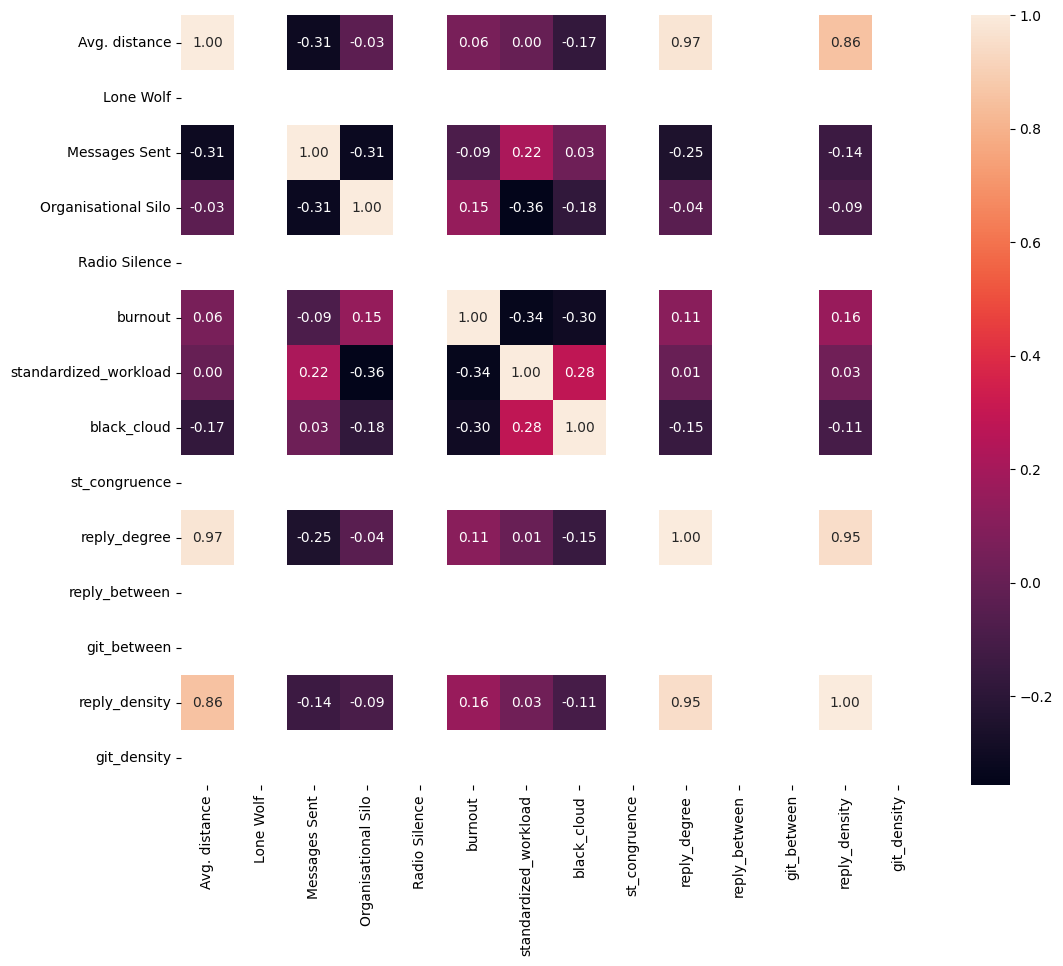

In [7]:
fig = plt.figure(figsize=(12,10))
ax= plt.subplot()
sns.heatmap(logistic_train_data.astype(float).corr(), annot=True, ax = ax, fmt = '.2f');
fig.savefig('correlations_geronimo.png')

In [8]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('burnout', axis = 1), logistic_train_data['burnout'])

Text(45.722222222222214, 0.5, 'True class')

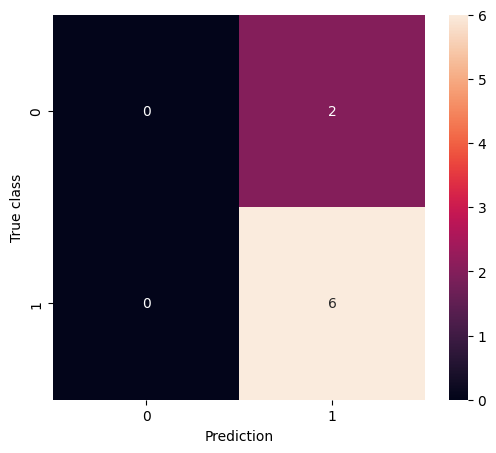

In [9]:
cm = confusion_matrix(logistic_test_data['burnout'], lr_model.predict(logistic_test_data.drop('burnout', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [10]:
stat_model = sm.Logit(logistic_train_data['burnout'].astype(float), sm.add_constant(logistic_train_data[['Avg. distance', 'standardized_workload',
 'Organisational Silo',  'black_cloud', 'Messages Sent']]).astype(float)).fit(disp = 0)
stat_model.summary()

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                burnout   No. Observations:                   32
Model:                          Logit   Df Residuals:                       26
Method:                           MLE   Df Model:                            5
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.2046
Time:                        14:13:14   Log-Likelihood:                -12.283
converged:                      False   LL-Null:                       -15.442
Covariance Type:            nonrobust   LLR p-value:                    0.2765
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    23.9150   6.03e+04      0.000      1.000   -1.18e+05    1.18e+05
Avg. distance             0.4006      1.439      0.278      0.781      -2.419       3.220
standardized_workload    -0.3659      0.329     -1.112      0.266      -1.011       0.279
Organisational Silo       0.0966      1.374      0.070      0.944      -2.597       2.790
black_cloud             -22.7267   6.03e+04     -0.000      1.000   -1.18e+05    1.18e+05
Messages Sent            -0.0006      0.140     -0.004      0.997      -0.274       0.273
=========================================================================================

Possibly complete quasi-separation: A fraction 0.28 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Text(45.722222222222214, 0.5, 'True class')

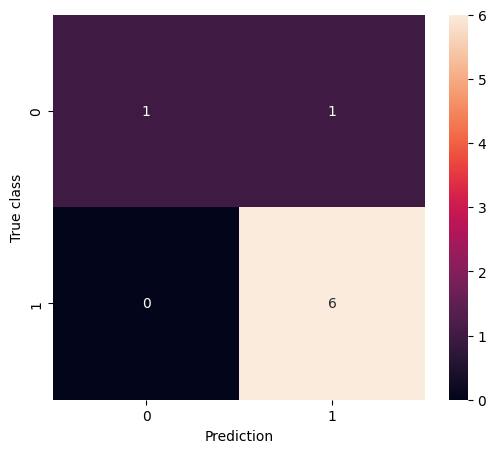

In [11]:
cm = confusion_matrix(logistic_test_data['burnout'], round(stat_model.predict(sm.add_constant(logistic_test_data[['Avg. distance', 'standardized_workload',
 'Organisational Silo',  'black_cloud', 'Messages Sent']]).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [12]:
message_data = all_test[['reply_body', 'burnout']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['burnout'] = message_data['burnout'].astype(bool)
message_data

100%|██████████| 181/181 [00:02<00:00, 63.62it/s] 


,reply_body,burnout,lemmas
1,i have written down one on the user the does t...,False,"[write, user, create, number, ledger, reach, l..."
21,a number of times when i start a clean it fail...,False,"[number, time, start, clean, fail, follow, err..."
28,there are use that add requests to a write upo...,False,"[use, add, request, write, ack, write, writing..."
43,if i start bookies i getting error messages li...,False,"[start, bookie, get, error, message, like, del..."
48,tries to read all entries from the bookie ense...,True,"[try, read, entry, bookie, ensemble, read, cli..."
...,...,...,...
351,we had a metadata & we need a metadata manager...,True,"[metadata, need, metadata, manager, implementa..."
359,"currently, due to the scan mechanism by garbag...",True,"[currently, scan, mechanism, garbage, thread, ..."
370,per it would be better to mechanism currently ...,True,"[well, mechanism, currently, client, avoid]"
384,currently we load all into memory when the top...,False,"[currently, load, memory, topic, load, subscri..."


In [13]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['burnout'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['burnout'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["burnout"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["burnout"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train['burnout']==1].index], message_train])
        print(f'Positive cases: {message_train["burnout"].sum()}')

        if 3*message_train["burnout"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train['burnout']==1].index], message_train])
            print(f'Positive cases: {message_train["burnout"].sum()}')

        nMax = message_train["burnout"].sum()
        message_train = message_train.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["burnout"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["burnout"].sum()}')
        message_train = message_train.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["burnout"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train['burnout']==0].index], message_train])
        print(f'Positive cases: {message_train["burnout"].sum()}')

        if message_train["burnout"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train['burnout']==0].index], message_train])
            print(f'Positive cases: {message_train["burnout"].sum()}')

        nMax = len(message_train) - message_train["burnout"].sum()
        message_train = message_train.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["burnout"].sum()
        print(f'Positive cases: {message_train["burnout"].sum()}')
        message_train = message_train.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 121
length of validation set: 26
length of test set: 27
Positive cases: 52
New length of train set: 104


C:\Users\woute\AppData\Local\Temp\ipykernel_19704\1081622227.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_19704\1081622227.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [14]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['burnout']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['burnout']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
Empty DataFrame
Columns: [pos_importance, pos_occur, total_appearances]
Index: []
negative 0:
Empty DataFrame
Columns: [neg_importance, neg_occur, total_appearances]
Index: []
----------------------------------------------------------------------------------------------------------------------------------------------
positive 25:
Empty DataFrame
Columns: [pos_importance, pos_occur, total_appearances]
Index: []
negative 25:
Empty DataFrame
Columns: [neg_importance, neg_occur, total_appearances]
Index: []
----------------------------------------------------------------------------------------------------------------------------------------------
positive 50:
Empty DataFrame
Columns: [pos_importance, pos_occur, total_appearances]
Index: []
negative 50:
Empty DataFrame
Columns: [neg_importance, neg_occur, total_appearances]
Index: []
----------------------------------------------------------------------------------------------------------------------------------------------
pos

In [19]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.71      0.67      0.69        18\n        True       0.33      0.38      0.35         8\n\n    accuracy                           0.58        26\n   macro avg       0.52      0.52      0.52        26\nweighted avg       0.59      0.58      0.58        26\n'

Text(45.722222222222214, 0.5, 'True class')

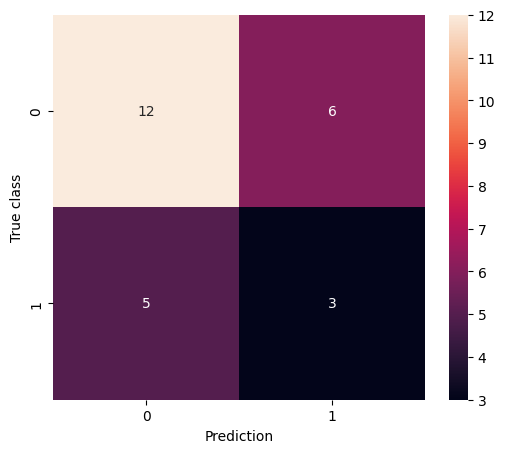

In [20]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [21]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.43      0.17      0.24        18\n        True       0.21      0.50      0.30         8\n\n    accuracy                           0.27        26\n   macro avg       0.32      0.33      0.27        26\nweighted avg       0.36      0.27      0.26        26\n'

Text(45.722222222222214, 0.5, 'True class')

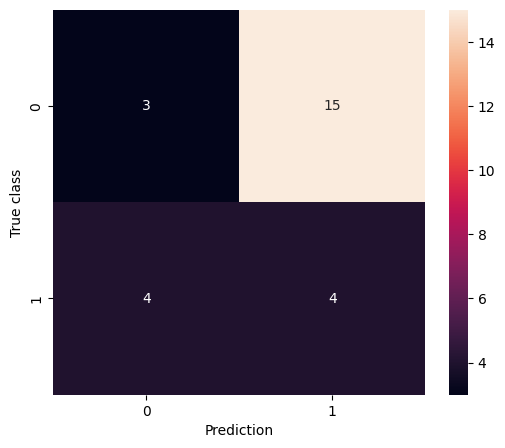

In [22]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [23]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.65      0.83      0.73        18\n        True       0.00      0.00      0.00         8\n\n    accuracy                           0.58        26\n   macro avg       0.33      0.42      0.37        26\nweighted avg       0.45      0.58      0.51        26\n'

Text(45.722222222222214, 0.5, 'True class')

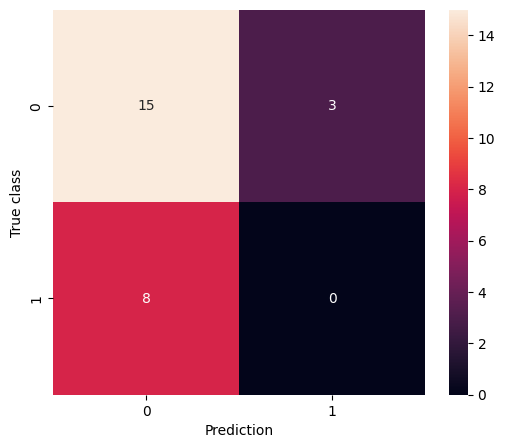

In [24]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [27]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.68      0.83      0.75        18\n        True       0.25      0.12      0.17         8\n\n    accuracy                           0.62        26\n   macro avg       0.47      0.48      0.46        26\nweighted avg       0.55      0.62      0.57        26\n'

Text(45.722222222222214, 0.5, 'True class')

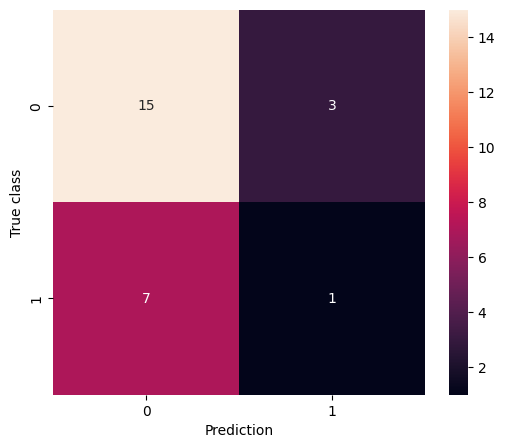

In [28]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [29]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.43      0.17      0.24        18\n        True       0.21      0.50      0.30         8\n\n    accuracy                           0.27        26\n   macro avg       0.32      0.33      0.27        26\nweighted avg       0.36      0.27      0.26        26\n'

Text(45.722222222222214, 0.5, 'True class')

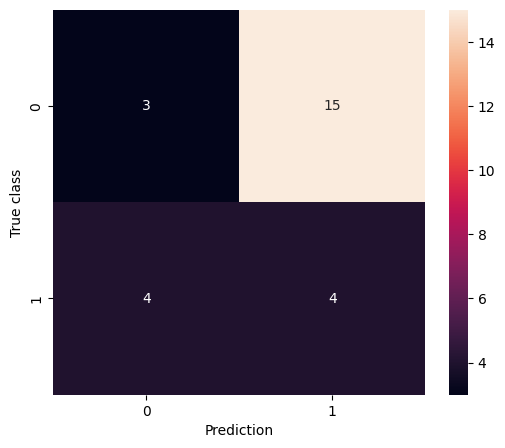

In [30]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [31]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.70      0.89      0.78        18\n        True       0.33      0.12      0.18         8\n\n    accuracy                           0.65        26\n   macro avg       0.51      0.51      0.48        26\nweighted avg       0.58      0.65      0.60        26\n'

Text(45.722222222222214, 0.5, 'True class')

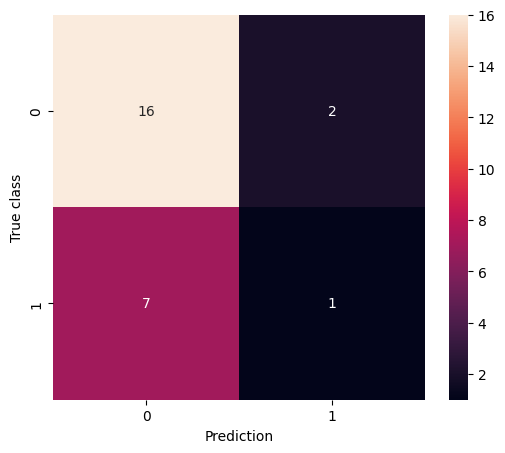

In [32]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# Ragequit - LR

sklearn

In [33]:
burnout_logistic_data = logistic_data[~logistic_data['ragequit_t+1'].isna()].drop(['burnout_t+1', 'burnout_t+3', 'burnout_t+12', 'burnout', 'ragequit_t+3', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1).dropna().astype({'ragequit_t+1':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data[['ragequit_t+1', 'Lone Wolf']])

In [34]:
burnout_logistic_data.describe(include = 'all')

,Avg. distance,Lone Wolf,Messages Sent,Organisational Silo,Radio Silence,standardized_workload,black_cloud,ragequit_t+1,st_congruence,reply_degree,reply_between,git_between,reply_density,git_density
count,40.000000,40,40.000000,40,40,40.000000,40,40,40.0,40.000000,40.0,40.0,40.000000,40.0
unique,NaN,1,NaN,2,1,NaN,2,1,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,True,NaN,False,True,NaN,True,False,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,40,NaN,27,40,NaN,30,40,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.225000,NaN,6.500000,NaN,NaN,1.328277,NaN,NaN,0.0,0.026845,0.0,0.0,0.012738,1.0
std,0.422902,NaN,4.181768,NaN,NaN,1.893651,NaN,NaN,0.0,0.051861,0.0,0.0,0.028552,0.0
min,1.000000,NaN,1.000000,NaN,NaN,0.010680,NaN,NaN,0.0,0.000000,0.0,0.0,0.000000,1.0
25%,1.000000,NaN,3.000000,NaN,NaN,0.182811,NaN,NaN,0.0,0.000000,0.0,0.0,0.000000,1.0
50%,1.000000,NaN,6.000000,NaN,NaN,0.520942,NaN,NaN,0.0,0.000000,0.0,0.0,0.000000,1.0
75%,1.000000,NaN,9.250000,NaN,NaN,1.461351,NaN,NaN,0.0,0.000000,0.0,0.0,0.000000,1.0


In [42]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('ragequit_t+1', axis = 1), logistic_train_data['ragequit_t+1'])

ValueError: Found array with 0 sample(s) (shape=(0, 13)) while a minimum of 1 is required by LogisticRegressionCV.

In [ ]:
cm = confusion_matrix(logistic_test_data['ragequit_t+1'], lr_model.predict(logistic_test_data.drop('ragequit_t+1', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [ ]:
stat_model = sm.Logit(logistic_train_data['ragequit_t+1'].astype(float), sm.add_constant(logistic_train_data[['Avg. distance', 'standardized_workload',
 'Organisational Silo',  'black_cloud', 'Messages Sent', 'reply_degree']]).astype(float)).fit(disp = 0)
stat_model.summary()

In [ ]:
cm = confusion_matrix(logistic_test_data['ragequit_t+1'], round(stat_model.predict(sm.add_constant(logistic_test_data[['Avg. distance', 'standardized_workload',
 'Organisational Silo',  'black_cloud', 'Messages Sent', 'reply_degree']]).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [35]:
message_data = all_test[['reply_body', 'ragequit_t+1']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['ragequit_t+1'] = message_data['ragequit_t+1'].astype(bool)
message_data

100%|██████████| 423/423 [00:04<00:00, 85.52it/s] 


,reply_body,ragequit_t+1,lemmas
0,check,False,[check]
1,i have written down one on the user the does t...,False,"[write, user, create, number, ledger, reach, l..."
2,check,False,[check]
3,NegativeSentiment test NegativeSentiment test,False,"[NegativeSentiment, test, NegativeSentiment, t..."
4,test failure when checking the release,False,"[test, failure, check, release]"
...,...,...,...
429,"currently, bookkeeper client still write ledge...",False,"[currently, bookkeeper, client, write, ledger,..."
430,we changed ledgers to let consumed messages be...,False,"[change, ledger, let, consume, message, garbag..."
431,if there are lots of pending topic we should h...,False,"[lot, pende, topic, hub, pende, request, acces..."
432,currently use same ledger metadata during ledg...,False,"[currently, use, ledger, metadata, ledger, wri..."


In [36]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['ragequit_t+1'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['ragequit_t+1'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["ragequit_t+1"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["ragequit_t+1"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+1"]==1].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')

        if 3*message_train["ragequit_t+1"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+1"]==1].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')

        nMax = message_train["ragequit_t+1"].sum()
        message_train = message_train.groupby("ragequit_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["ragequit_t+1"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')
        message_train = message_train.groupby("ragequit_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["ragequit_t+1"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+1"]==0].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')

        if message_train["ragequit_t+1"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+1"]==0].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')

        nMax = len(message_train) - message_train["ragequit_t+1"].sum()
        message_train = message_train.groupby("ragequit_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["ragequit_t+1"].sum()
        print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')
        message_train = message_train.groupby("ragequit_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 284
length of validation set: 62
length of test set: 62
Positive cases: 2
Positive cases: 6
New length of train set: 12


C:\Users\woute\AppData\Local\Temp\ipykernel_19704\1360335003.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_19704\1360335003.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("ragequit_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [37]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['ragequit_t+1']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['ragequit_t+1']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
                   pos_importance  pos_occur  total_appearances
entry                         0.0        0.0              122.0
PositiveSentiment             0.0        0.0              115.0
ledger                        0.0        0.0              196.0
bookie                        0.0        0.0              146.0
negative 0:
                   neg_importance  neg_occur  total_appearances
entry                         1.0        122              122.0
PositiveSentiment             1.0        115              115.0
ledger                        1.0        196              196.0
bookie                        1.0        146              146.0
----------------------------------------------------------------------------------------------------------------------------------------------
positive 25:
                   pos_importance  pos_occur  total_appearances
PositiveSentiment        0.151515        0.0              115.0
entry                    0.145349        0.0        

In [38]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.98      0.90      0.94        61\n        True       0.00      0.00      0.00         1\n\n    accuracy                           0.89        62\n   macro avg       0.49      0.45      0.47        62\nweighted avg       0.97      0.89      0.93        62\n'

Text(45.722222222222214, 0.5, 'True class')

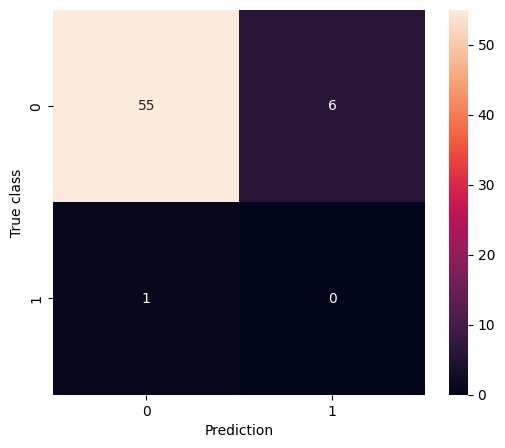

In [39]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [47]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_train.lemmas.to_list(), vector_size = 300, min_count = 2, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

'              precision    recall  f1-score   support\n\n       False       0.98      1.00      0.99        61\n        True       0.00      0.00      0.00         1\n\n    accuracy                           0.98        62\n   macro avg       0.49      0.50      0.50        62\nweighted avg       0.97      0.98      0.98        62\n'

Text(45.722222222222214, 0.5, 'True class')

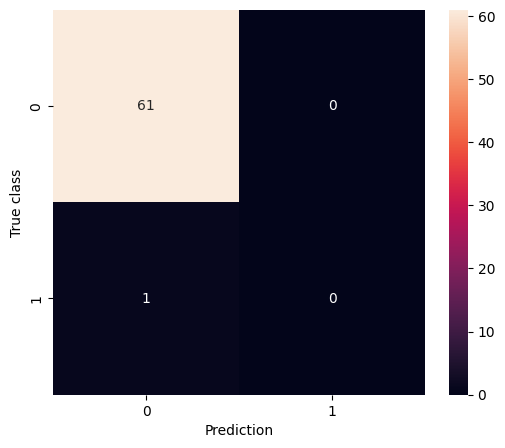

In [48]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [49]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

'              precision    recall  f1-score   support\n\n       False       0.98      1.00      0.99        61\n        True       0.00      0.00      0.00         1\n\n    accuracy                           0.98        62\n   macro avg       0.49      0.50      0.50        62\nweighted avg       0.97      0.98      0.98        62\n'

Text(45.722222222222214, 0.5, 'True class')

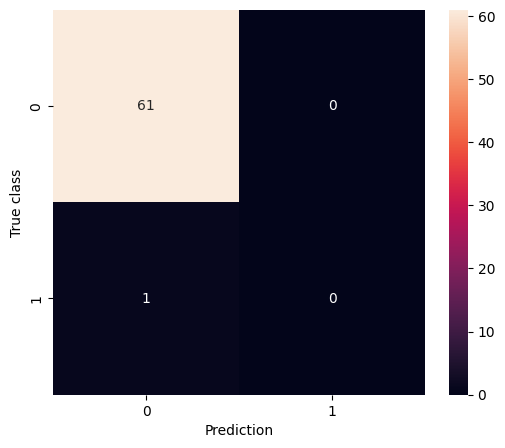

In [50]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [51]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site

'              precision    recall  f1-score   support\n\n       False       0.98      1.00      0.99        61\n        True       0.00      0.00      0.00         1\n\n    accuracy                           0.98        62\n   macro avg       0.49      0.50      0.50        62\nweighted avg       0.97      0.98      0.98        62\n'

Text(45.722222222222214, 0.5, 'True class')

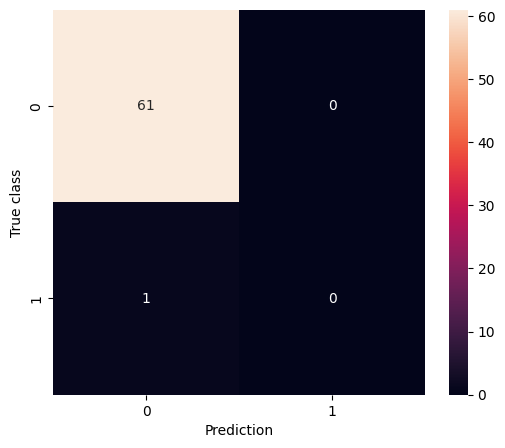

In [52]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [53]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_train.lemmas.to_list(), vector_size = 300, min_count = 2, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.98      0.93      0.96        61\n        True       0.00      0.00      0.00         1\n\n    accuracy                           0.92        62\n   macro avg       0.49      0.47      0.48        62\nweighted avg       0.97      0.92      0.94        62\n'

Text(45.722222222222214, 0.5, 'True class')

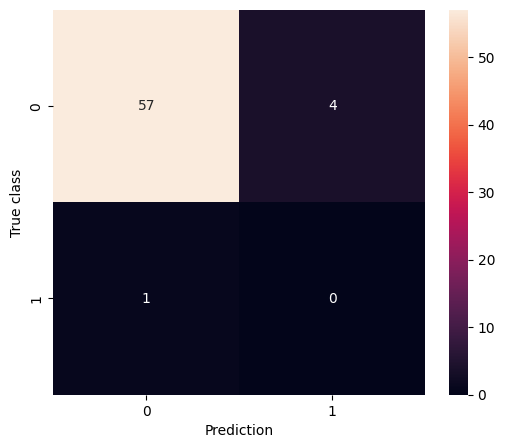

In [54]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [55]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

'              precision    recall  f1-score   support\n\n       False       0.98      1.00      0.99        61\n        True       0.00      0.00      0.00         1\n\n    accuracy                           0.98        62\n   macro avg       0.49      0.50      0.50        62\nweighted avg       0.97      0.98      0.98        62\n'

Text(45.722222222222214, 0.5, 'True class')

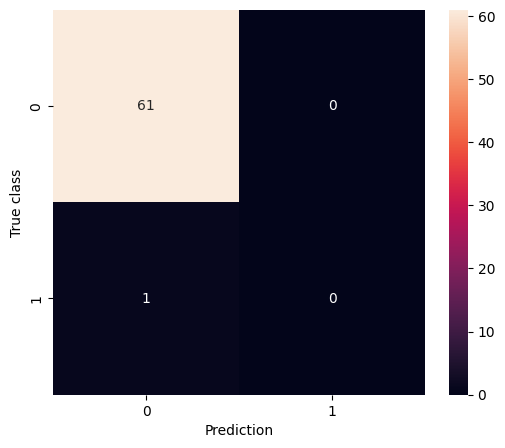

In [56]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# Lagged variables

## Burnout t+1

In [57]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1).dropna().astype({'burnout_t+1':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['burnout_t+1'])


In [58]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('burnout_t+1', axis = 1), logistic_train_data['burnout_t+1'])

Text(45.722222222222214, 0.5, 'True class')

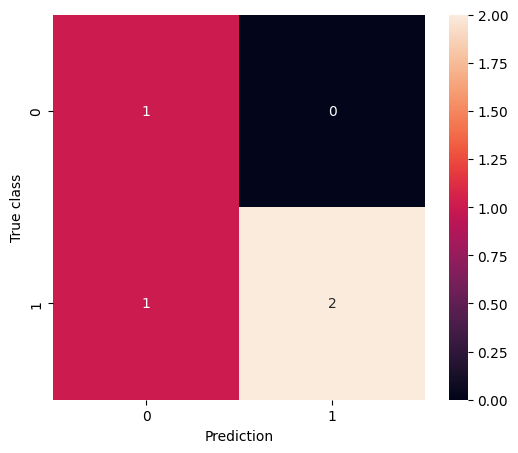

In [59]:
cm = confusion_matrix(logistic_test_data['burnout_t+1'], lr_model.predict(logistic_test_data.drop('burnout_t+1', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [60]:
stat_model = sm.Logit(logistic_train_data['burnout_t+1'].astype(float), sm.add_constant(logistic_train_data[['Avg. distance', 'standardized_workload',
 'Organisational Silo',  'black_cloud', 'Messages Sent', 'reply_degree']]).astype(float)).fit(disp = 0)
stat_model.summary()

LinAlgError: Singular matrix

In [ ]:
cm = confusion_matrix(logistic_test_data['burnout_t+1'], round(stat_model.predict(sm.add_constant(logistic_test_data[['Avg. distance', 'standardized_workload',
 'Organisational Silo',  'black_cloud', 'Messages Sent', 'reply_degree']]).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [61]:
message_data = all_test[['reply_body', 'burnout_t+1']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['burnout_t+1'] = message_data['burnout_t+1'].astype(bool)
message_data

100%|██████████| 199/199 [00:02<00:00, 87.11it/s] 


,reply_body,burnout_t+1,lemmas
1,i have written down one on the user the does t...,False,"[write, user, create, number, ledger, reach, l..."
14,just fixes of,False,[fix]
15,as per a we would like to two metrics related ...,False,"[like, metric, relate, performance, bookie, op..."
21,a number of times when i start a clean it fail...,False,"[number, time, start, clean, fail, follow, err..."
28,there are use that add requests to a write upo...,False,"[use, add, request, write, ack, write, writing..."
...,...,...,...
359,"currently, due to the scan mechanism by garbag...",True,"[currently, scan, mechanism, garbage, thread, ..."
370,per it would be better to mechanism currently ...,True,"[well, mechanism, currently, client, avoid]"
384,currently we load all into memory when the top...,False,"[currently, load, memory, topic, load, subscri..."
390,need a based active ledger server.,True,"[need, base, active, ledger, server]"


In [62]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['burnout_t+1'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['burnout_t+1'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["burnout_t+1"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["burnout_t+1"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train['burnout_t+1']==1].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+1"].sum()}')

        if 3*message_train["burnout_t+1"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+1"]==1].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+1"].sum()}')

        nMax = message_train["burnout_t+1"].sum()
        message_train = message_train.groupby("burnout_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["burnout_t+1"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["burnout_t+1"].sum()}')
        message_train = message_train.groupby("burnout_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["burnout_t+1"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+1"]==0].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+1"].sum()}')

        if message_train["burnout_t+1"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+1"]==0].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+1"].sum()}')

        nMax = len(message_train) - message_train["burnout_t+1"].sum()
        message_train = message_train.groupby("burnout_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["burnout_t+1"].sum()
        print(f'Positive cases: {message_train["burnout_t+1"].sum()}')
        message_train = message_train.groupby("burnout_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 134
length of validation set: 29
length of test set: 29
Positive cases: 59
New length of train set: 74


C:\Users\woute\AppData\Local\Temp\ipykernel_19704\995443566.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_19704\995443566.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("burnout_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [63]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['burnout_t+1']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['burnout_t+1']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
Empty DataFrame
Columns: [pos_importance, pos_occur, total_appearances]
Index: []
negative 0:
Empty DataFrame
Columns: [neg_importance, neg_occur, total_appearances]
Index: []
----------------------------------------------------------------------------------------------------------------------------------------------
positive 25:
Empty DataFrame
Columns: [pos_importance, pos_occur, total_appearances]
Index: []
negative 25:
Empty DataFrame
Columns: [neg_importance, neg_occur, total_appearances]
Index: []
----------------------------------------------------------------------------------------------------------------------------------------------
positive 50:
Empty DataFrame
Columns: [pos_importance, pos_occur, total_appearances]
Index: []
negative 50:
Empty DataFrame
Columns: [neg_importance, neg_occur, total_appearances]
Index: []
----------------------------------------------------------------------------------------------------------------------------------------------
pos

In [64]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.63      1.00      0.77        12\n        True       1.00      0.59      0.74        17\n\n    accuracy                           0.76        29\n   macro avg       0.82      0.79      0.76        29\nweighted avg       0.85      0.76      0.75        29\n'

Text(45.722222222222214, 0.5, 'True class')

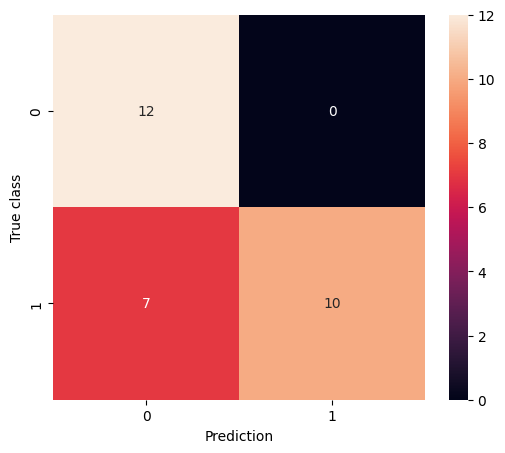

In [65]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [66]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.67      0.33      0.44        12\n        True       0.65      0.88      0.75        17\n\n    accuracy                           0.66        29\n   macro avg       0.66      0.61      0.60        29\nweighted avg       0.66      0.66      0.62        29\n'

Text(45.722222222222214, 0.5, 'True class')

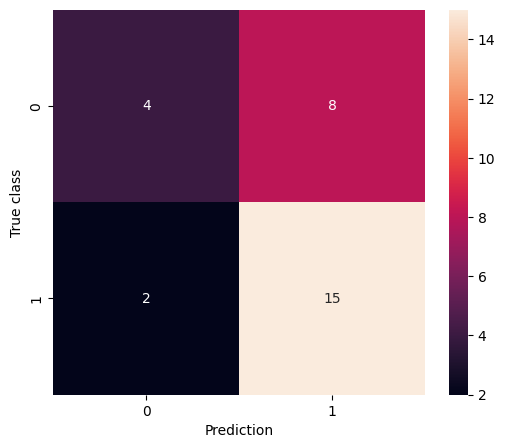

In [67]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [68]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.47      0.75      0.58        12\n        True       0.70      0.41      0.52        17\n\n    accuracy                           0.55        29\n   macro avg       0.59      0.58      0.55        29\nweighted avg       0.61      0.55      0.54        29\n'

Text(45.722222222222214, 0.5, 'True class')

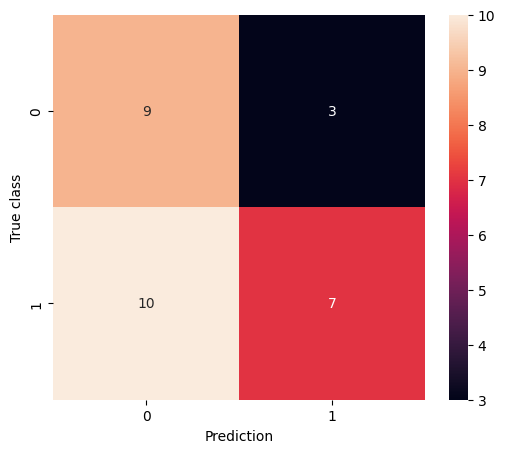

In [69]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [71]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.53      0.75      0.62        12\n        True       0.75      0.53      0.62        17\n\n    accuracy                           0.62        29\n   macro avg       0.64      0.64      0.62        29\nweighted avg       0.66      0.62      0.62        29\n'

Text(45.722222222222214, 0.5, 'True class')

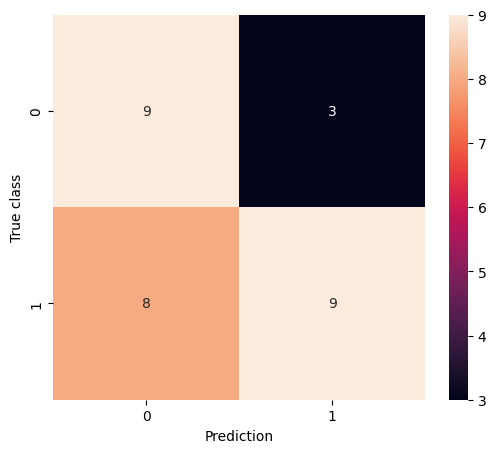

In [72]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [73]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       1.00      0.17      0.29        12\n        True       0.63      1.00      0.77        17\n\n    accuracy                           0.66        29\n   macro avg       0.81      0.58      0.53        29\nweighted avg       0.78      0.66      0.57        29\n'

Text(45.722222222222214, 0.5, 'True class')

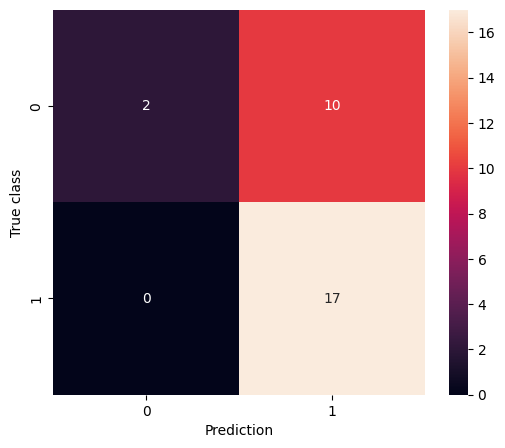

In [74]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [75]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.50      0.75      0.60        12\n        True       0.73      0.47      0.57        17\n\n    accuracy                           0.59        29\n   macro avg       0.61      0.61      0.59        29\nweighted avg       0.63      0.59      0.58        29\n'

Text(45.722222222222214, 0.5, 'True class')

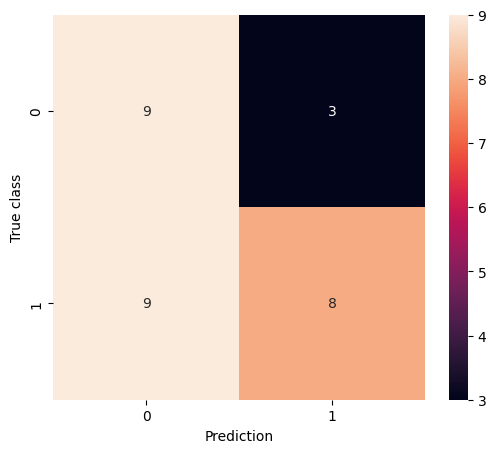

In [76]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

## Burnout_t+3

In [77]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout_t+1', 'burnout', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1).dropna().astype({'burnout_t+3':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['burnout_t+3'])

In [78]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('burnout_t+3', axis = 1), logistic_train_data['burnout_t+3'])

Text(45.722222222222214, 0.5, 'True class')

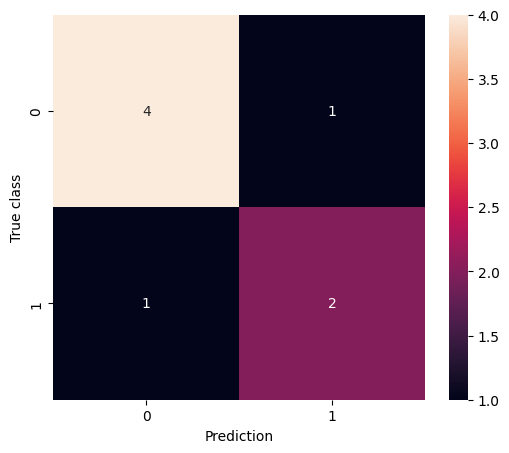

In [79]:
cm = confusion_matrix(logistic_test_data['burnout_t+3'], lr_model.predict(logistic_test_data.drop('burnout_t+3', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [80]:
stat_model = sm.Logit(logistic_train_data['burnout_t+3'].astype(float), sm.add_constant(logistic_train_data[['Avg. distance', 'standardized_workload',
 'Organisational Silo',  'black_cloud', 'Messages Sent', 'reply_degree']]).astype(float)).fit(disp = 0)
stat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            burnout_t+3   No. Observations:                   32
Model:                          Logit   Df Residuals:                       25
Method:                           MLE   Df Model:                            6
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.5294
Time:                        14:20:26   Log-Likelihood:                -10.172
converged:                       True   LL-Null:                       -21.615
Covariance Type:            nonrobust   LLR p-value:                 0.0008355
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     6.4918      8.641      0.751      0.452     -10.444      23.428
Avg. distance           -13.7089      9.725     -1.410      0.159     -32.770       5.352
standardized_workload     1.2947      1.165      1.111      0.267      -0.989       3.578
Organisational Silo      -0.6453      1.597     -0.404      0.686      -3.776       2.486
black_cloud               3.8100      2.074      1.837      0.066      -0.254       7.874
Messages Sent             0.3914      0.184      2.131      0.033       0.031       0.751
reply_degree            109.2304     73.059      1.495      0.135     -33.962     252.422
=========================================================================================
"""

Text(45.722222222222214, 0.5, 'True class')

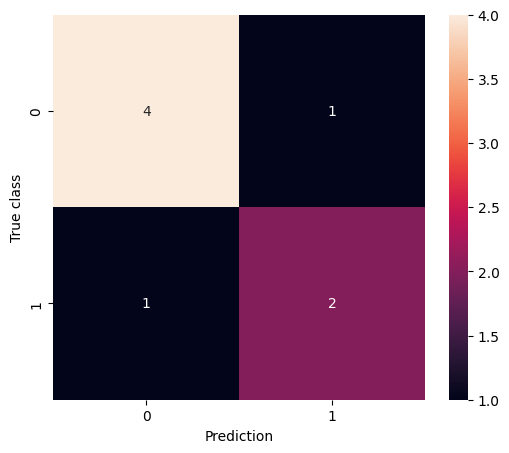

In [81]:
cm = confusion_matrix(logistic_test_data['burnout_t+3'], round(stat_model.predict(sm.add_constant(logistic_test_data[['Avg. distance', 'standardized_workload',
 'Organisational Silo',  'black_cloud', 'Messages Sent', 'reply_degree']], has_constant = 'add').astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [82]:
message_data = all_test[['reply_body', 'burnout_t+3']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['burnout_t+3'] = message_data['burnout_t+3'].astype(bool)
message_data

100%|██████████| 423/423 [00:04<00:00, 104.93it/s]


,reply_body,burnout_t+3,lemmas
0,check,False,[check]
1,i have written down one on the user the does t...,False,"[write, user, create, number, ledger, reach, l..."
2,check,False,[check]
3,NegativeSentiment test NegativeSentiment test,False,"[NegativeSentiment, test, NegativeSentiment, t..."
4,test failure when checking the release,False,"[test, failure, check, release]"
...,...,...,...
429,"currently, bookkeeper client still write ledge...",False,"[currently, bookkeeper, client, write, ledger,..."
430,we changed ledgers to let consumed messages be...,False,"[change, ledger, let, consume, message, garbag..."
431,if there are lots of pending topic we should h...,False,"[lot, pende, topic, hub, pende, request, acces..."
432,currently use same ledger metadata during ledg...,False,"[currently, use, ledger, metadata, ledger, wri..."


In [83]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['burnout_t+3'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['burnout_t+3'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["burnout_t+3"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["burnout_t+3"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+3"]==1].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+3"].sum()}')

        if 3*message_train["burnout_t+3"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+3"]==1].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+3"].sum()}')

        nMax = message_train["burnout_t+3"].sum()
        message_train = message_train.groupby("burnout_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["burnout_t+3"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["burnout_t+3"].sum()}')
        message_train = message_train.groupby("burnout_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["burnout_t+3"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+3"]==0].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+3"].sum()}')

        if message_train["burnout_t+3"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+3"]==0].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+3"].sum()}')

        nMax = len(message_train) - message_train["burnout_t+3"].sum()
        message_train = message_train.groupby("burnout_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["burnout_t+3"].sum()
        print(f'Positive cases: {message_train["burnout_t+3"].sum()}')
        message_train = message_train.groupby("burnout_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 284
length of validation set: 62
length of test set: 62
Positive cases: 90
New length of train set: 180


C:\Users\woute\AppData\Local\Temp\ipykernel_19704\1913014158.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_19704\1913014158.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("burnout_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [84]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['burnout_t+3']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['burnout_t+3']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
                   pos_importance  pos_occur  total_appearances
entry                    0.614754       75.0              122.0
bookie                   0.520548       76.0              146.0
ledger                   0.403061       79.0              196.0
PositiveSentiment        0.313043       36.0              115.0
negative 0:
                   neg_importance  neg_occur  total_appearances
PositiveSentiment        0.686957       79.0              115.0
ledger                   0.596939      117.0              196.0
bookie                   0.479452       70.0              146.0
entry                    0.385246       47.0              122.0
----------------------------------------------------------------------------------------------------------------------------------------------
positive 25:
                   pos_importance  pos_occur  total_appearances
entry                    0.581395       75.0              122.0
bookie                   0.515306       76.0        

In [85]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.67      0.65      0.66        34\n        True       0.59      0.61      0.60        28\n\n    accuracy                           0.63        62\n   macro avg       0.63      0.63      0.63        62\nweighted avg       0.63      0.63      0.63        62\n'

Text(45.722222222222214, 0.5, 'True class')

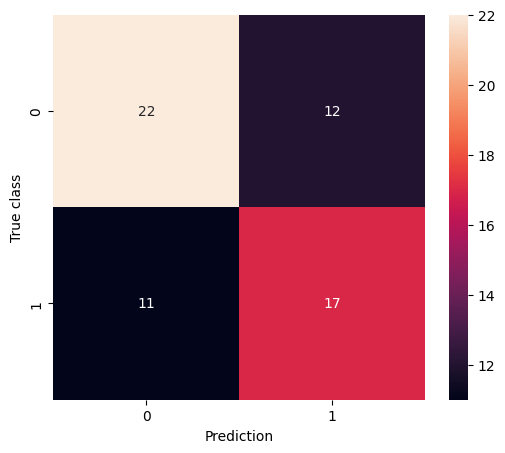

In [86]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [87]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.53      0.53      0.53        34\n        True       0.43      0.43      0.43        28\n\n    accuracy                           0.48        62\n   macro avg       0.48      0.48      0.48        62\nweighted avg       0.48      0.48      0.48        62\n'

Text(45.722222222222214, 0.5, 'True class')

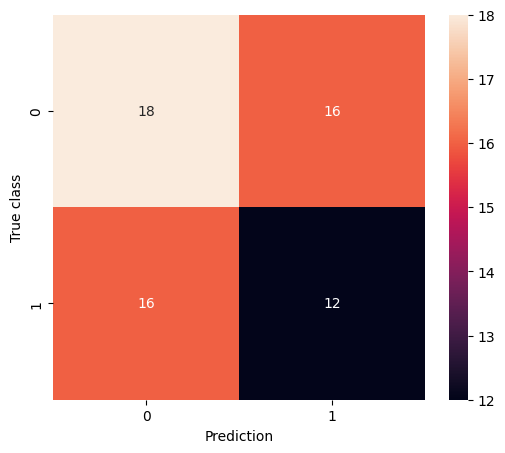

In [88]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [89]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.63      0.56      0.59        34\n        True       0.53      0.61      0.57        28\n\n    accuracy                           0.58        62\n   macro avg       0.58      0.58      0.58        62\nweighted avg       0.59      0.58      0.58        62\n'

Text(45.722222222222214, 0.5, 'True class')

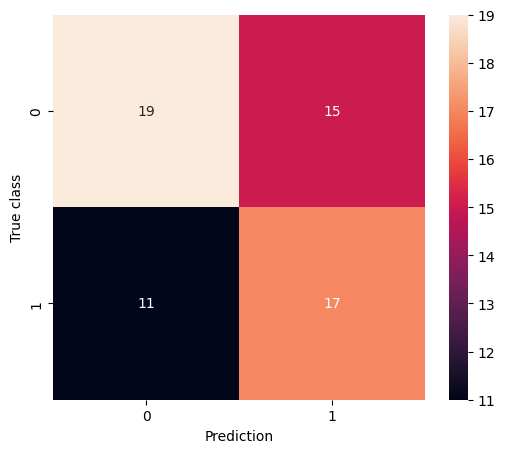

In [90]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [91]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.70      0.47      0.56        34\n        True       0.54      0.75      0.63        28\n\n    accuracy                           0.60        62\n   macro avg       0.62      0.61      0.59        62\nweighted avg       0.62      0.60      0.59        62\n'

Text(45.722222222222214, 0.5, 'True class')

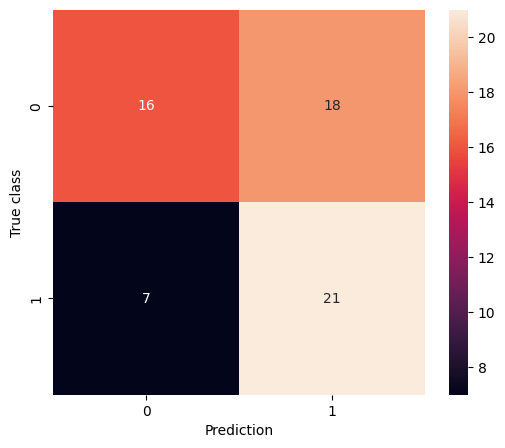

In [92]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [93]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.51      0.62      0.56        34\n        True       0.38      0.29      0.33        28\n\n    accuracy                           0.47        62\n   macro avg       0.45      0.45      0.44        62\nweighted avg       0.45      0.47      0.45        62\n'

Text(45.722222222222214, 0.5, 'True class')

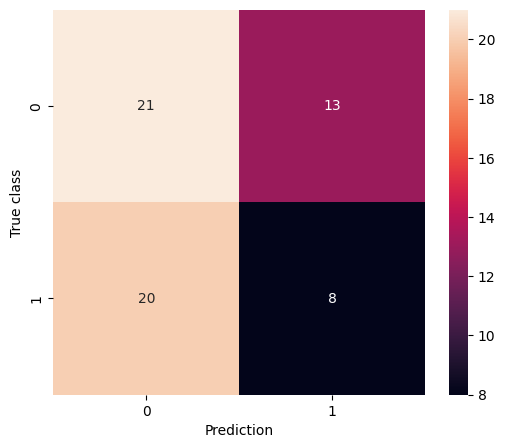

In [94]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [95]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.67      0.65      0.66        34\n        True       0.59      0.61      0.60        28\n\n    accuracy                           0.63        62\n   macro avg       0.63      0.63      0.63        62\nweighted avg       0.63      0.63      0.63        62\n'

Text(45.722222222222214, 0.5, 'True class')

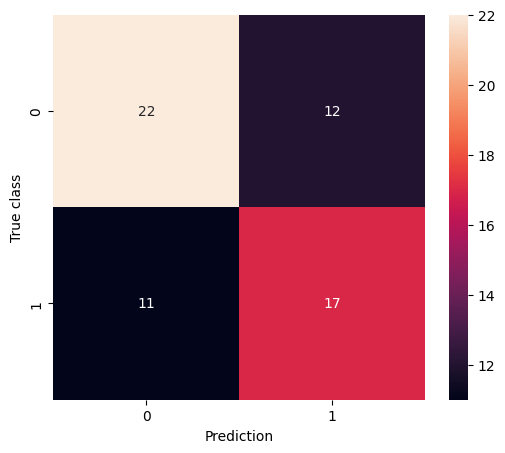

In [96]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

## Burnout T+12

In [97]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout_t+1', 'burnout_t+3', 'burnout', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1).dropna().astype({'burnout_t+12':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['burnout_t+12'])


In [98]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('burnout_t+12', axis = 1), logistic_train_data['burnout_t+12'])

Text(45.722222222222214, 0.5, 'True class')

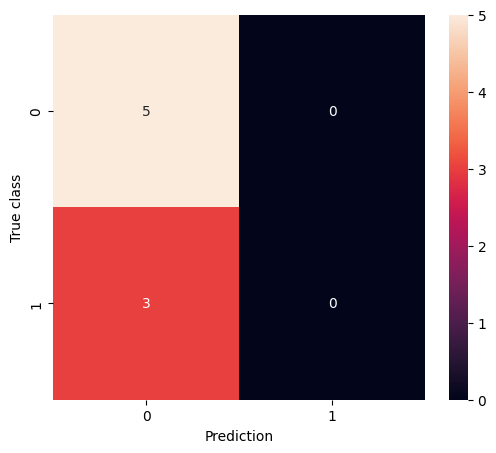

In [99]:
cm = confusion_matrix(logistic_test_data['burnout_t+12'], lr_model.predict(logistic_test_data.drop('burnout_t+12', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [100]:
stat_model = sm.Logit(logistic_train_data['burnout_t+12'].astype(float), sm.add_constant(logistic_train_data[['Avg. distance', 'standardized_workload',
 'Organisational Silo',  'black_cloud', 'Messages Sent']]).astype(float)).fit(disp = 0)
stat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           burnout_t+12   No. Observations:                   32
Model:                          Logit   Df Residuals:                       26
Method:                           MLE   Df Model:                            5
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.6426
Time:                        14:21:29   Log-Likelihood:                -7.8383
converged:                       True   LL-Null:                       -21.930
Covariance Type:            nonrobust   LLR p-value:                 3.351e-05
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -21.7367     12.178     -1.785      0.074     -45.606       2.132
Avg. distance             7.2185      4.410      1.637      0.102      -1.425      15.862
standardized_workload     2.6728      1.721      1.553      0.120      -0.699       6.045
Organisational Silo       4.1079      3.279      1.253      0.210      -2.319      10.535
black_cloud               4.5785      2.686      1.704      0.088      -0.686       9.843
Messages Sent             0.7289      0.427      1.708      0.088      -0.107       1.565
=========================================================================================

Possibly complete quasi-separation: A fraction 0.19 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Text(45.722222222222214, 0.5, 'True class')

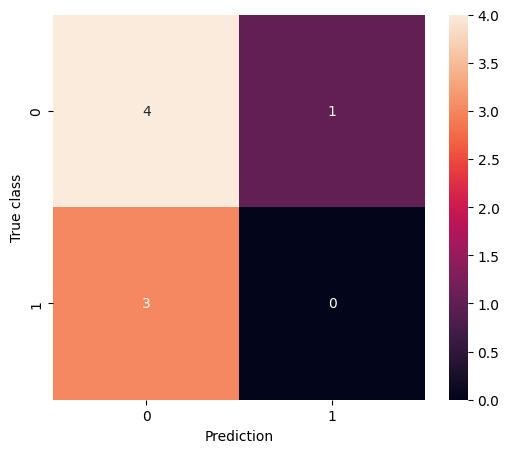

In [101]:
cm = confusion_matrix(logistic_test_data['burnout_t+12'], round(stat_model.predict(sm.add_constant(logistic_test_data[['Avg. distance', 'standardized_workload',
 'Organisational Silo',  'black_cloud', 'Messages Sent']]).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [102]:
message_data = all_test[['reply_body', 'burnout_t+12']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['burnout_t+12'] = message_data['burnout_t+12'].astype(bool)
message_data

100%|██████████| 423/423 [00:05<00:00, 83.08it/s] 


,reply_body,burnout_t+12,lemmas
0,check,False,[check]
1,i have written down one on the user the does t...,False,"[write, user, create, number, ledger, reach, l..."
2,check,False,[check]
3,NegativeSentiment test NegativeSentiment test,False,"[NegativeSentiment, test, NegativeSentiment, t..."
4,test failure when checking the release,False,"[test, failure, check, release]"
...,...,...,...
429,"currently, bookkeeper client still write ledge...",False,"[currently, bookkeeper, client, write, ledger,..."
430,we changed ledgers to let consumed messages be...,False,"[change, ledger, let, consume, message, garbag..."
431,if there are lots of pending topic we should h...,False,"[lot, pende, topic, hub, pende, request, acces..."
432,currently use same ledger metadata during ledg...,False,"[currently, use, ledger, metadata, ledger, wri..."


In [103]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['burnout_t+12'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['burnout_t+12'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["burnout_t+12"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["burnout_t+12"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+12"]==1].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+12"].sum()}')

        if 3*message_train["burnout_t+12"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+12"]==1].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+12"].sum()}')

        nMax = message_train["burnout_t+12"].sum()
        message_train = message_train.groupby("burnout_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["burnout_t+12"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["burnout_t+12"].sum()}')
        message_train = message_train.groupby("burnout_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["burnout_t+12"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+12"]==0].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+12"].sum()}')

        if message_train["burnout_t+12"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+12"]==0].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+12"].sum()}')

        nMax = len(message_train) - message_train["burnout_t+12"].sum()
        message_train = message_train.groupby("burnout_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["burnout_t+12"].sum()
        print(f'Positive cases: {message_train["burnout_t+12"].sum()}')
        message_train = message_train.groupby("burnout_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 284
length of validation set: 62
length of test set: 62
Positive cases: 97
New length of train set: 194


C:\Users\woute\AppData\Local\Temp\ipykernel_19704\188543492.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_19704\188543492.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("burnout_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [104]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['burnout_t+12']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['burnout_t+12']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
                   pos_importance  pos_occur  total_appearances
entry                    0.622951       76.0              122.0
bookie                   0.527397       77.0              146.0
ledger                   0.418367       82.0              196.0
PositiveSentiment        0.373913       43.0              115.0
negative 0:
                   neg_importance  neg_occur  total_appearances
PositiveSentiment        0.626087       72.0              115.0
ledger                   0.581633      114.0              196.0
bookie                   0.472603       69.0              146.0
entry                    0.377049       46.0              122.0
----------------------------------------------------------------------------------------------------------------------------------------------
positive 25:
                   pos_importance  pos_occur  total_appearances
entry                    0.587209       76.0              122.0
bookie                   0.520408       77.0        

In [105]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.61      0.57      0.59        30\n        True       0.62      0.66      0.64        32\n\n    accuracy                           0.61        62\n   macro avg       0.61      0.61      0.61        62\nweighted avg       0.61      0.61      0.61        62\n'

Text(45.722222222222214, 0.5, 'True class')

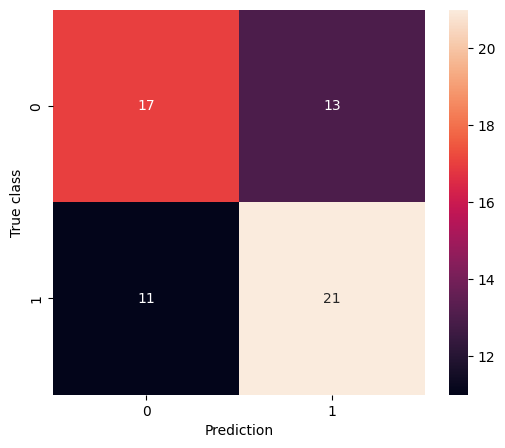

In [106]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [107]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.45      0.33      0.38        30\n        True       0.50      0.62      0.56        32\n\n    accuracy                           0.48        62\n   macro avg       0.48      0.48      0.47        62\nweighted avg       0.48      0.48      0.47        62\n'

Text(45.722222222222214, 0.5, 'True class')

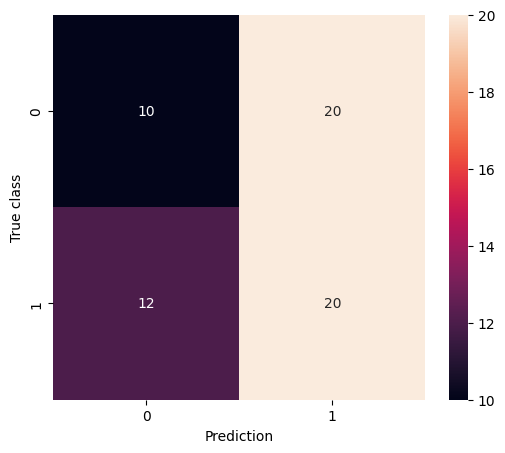

In [108]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [109]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.55      0.57      0.56        30\n        True       0.58      0.56      0.57        32\n\n    accuracy                           0.56        62\n   macro avg       0.56      0.56      0.56        62\nweighted avg       0.57      0.56      0.56        62\n'

Text(45.722222222222214, 0.5, 'True class')

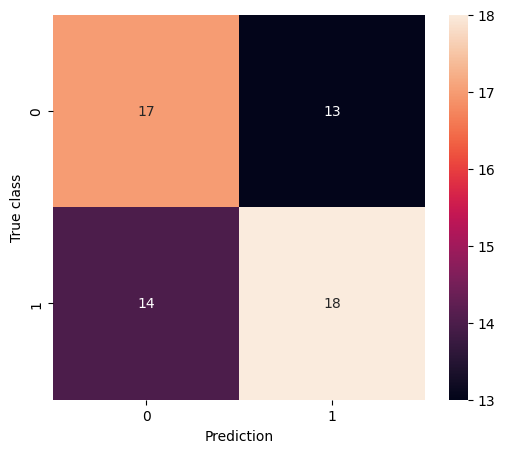

In [110]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [111]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.55      0.60      0.57        30\n        True       0.59      0.53      0.56        32\n\n    accuracy                           0.56        62\n   macro avg       0.57      0.57      0.56        62\nweighted avg       0.57      0.56      0.56        62\n'

Text(45.722222222222214, 0.5, 'True class')

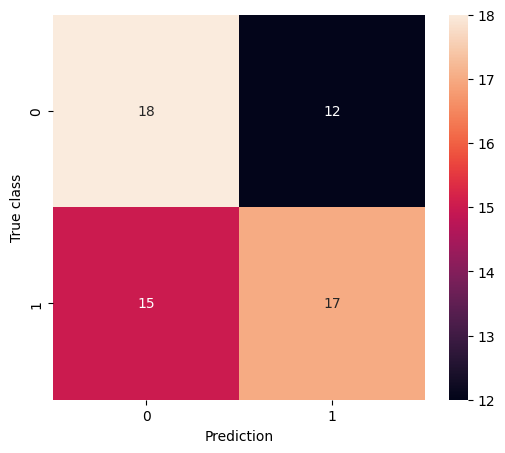

In [112]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [113]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.55      0.57      0.56        30\n        True       0.58      0.56      0.57        32\n\n    accuracy                           0.56        62\n   macro avg       0.56      0.56      0.56        62\nweighted avg       0.57      0.56      0.56        62\n'

Text(45.722222222222214, 0.5, 'True class')

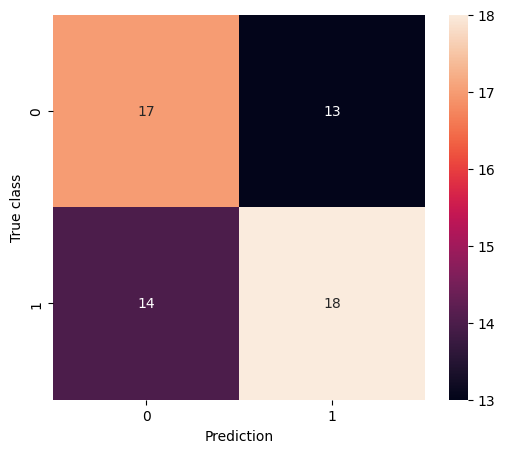

In [114]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [115]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.55      0.60      0.57        30\n        True       0.59      0.53      0.56        32\n\n    accuracy                           0.56        62\n   macro avg       0.57      0.57      0.56        62\nweighted avg       0.57      0.56      0.56        62\n'

Text(45.722222222222214, 0.5, 'True class')

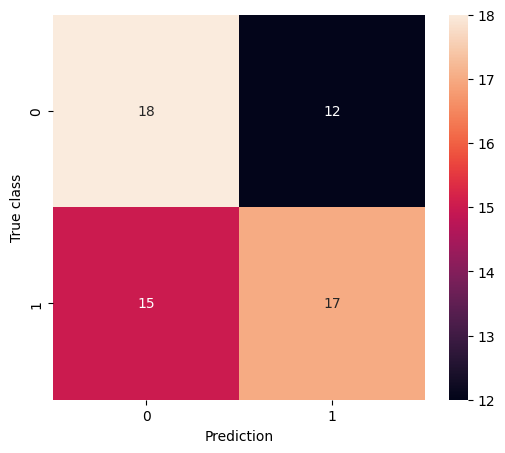

In [116]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

## Ragequit T+3

In [117]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout_t+1', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'burnout', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'Workload'], axis = 1).dropna().astype({'ragequit_t+3':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['ragequit_t+3'])

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('ragequit_t+3', axis = 1), logistic_train_data['ragequit_t+3'])

In [ ]:
cm = confusion_matrix(logistic_test_data['ragequit_t+3'], lr_model.predict(logistic_test_data.drop('ragequit_t+3', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [ ]:
stat_model = sm.Logit(logistic_train_data['ragequit_t+3'].astype(float), sm.add_constant(logistic_train_data[['Avg. distance', 'standardized_workload',
 'Organisational Silo',  'black_cloud', 'Messages Sent', 'reply_degree']]).astype(float)).fit(disp = 0)
stat_model.summary()

In [ ]:
cm = confusion_matrix(logistic_test_data['ragequit_t+3'], round(stat_model.predict(sm.add_constant(logistic_test_data[['Avg. distance', 'standardized_workload',
 'Organisational Silo',  'black_cloud', 'Messages Sent', 'reply_degree']]).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [119]:
message_data = all_test[['reply_body', 'ragequit_t+3']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['ragequit_t+3'] = message_data['ragequit_t+3'].astype(bool)
message_data

100%|██████████| 423/423 [00:04<00:00, 89.14it/s] 


,reply_body,ragequit_t+3,lemmas
0,check,False,[check]
1,i have written down one on the user the does t...,False,"[write, user, create, number, ledger, reach, l..."
2,check,False,[check]
3,NegativeSentiment test NegativeSentiment test,False,"[NegativeSentiment, test, NegativeSentiment, t..."
4,test failure when checking the release,False,"[test, failure, check, release]"
...,...,...,...
429,"currently, bookkeeper client still write ledge...",False,"[currently, bookkeeper, client, write, ledger,..."
430,we changed ledgers to let consumed messages be...,False,"[change, ledger, let, consume, message, garbag..."
431,if there are lots of pending topic we should h...,False,"[lot, pende, topic, hub, pende, request, acces..."
432,currently use same ledger metadata during ledg...,False,"[currently, use, ledger, metadata, ledger, wri..."


In [120]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['ragequit_t+3'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['ragequit_t+3'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["ragequit_t+3"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["ragequit_t+3"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+3"]==1].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')

        if 3*message_train["ragequit_t+3"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+3"]==1].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')

        nMax = message_train["ragequit_t+3"].sum()
        message_train = message_train.groupby("ragequit_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["ragequit_t+3"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')
        message_train = message_train.groupby("ragequit_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["ragequit_t+3"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+3"]==0].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')

        if message_train["ragequit_t+3"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+3"]==0].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')

        nMax = len(message_train) - message_train["ragequit_t+3"].sum()
        message_train = message_train.groupby("ragequit_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["ragequit_t+3"].sum()
        print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')
        message_train = message_train.groupby("ragequit_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 284
length of validation set: 62
length of test set: 62
Positive cases: 2
Positive cases: 6
New length of train set: 12


C:\Users\woute\AppData\Local\Temp\ipykernel_19704\3232222597.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_19704\3232222597.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("ragequit_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [121]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['ragequit_t+3']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['ragequit_t+3']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
                   pos_importance  pos_occur  total_appearances
entry                         0.0        0.0              122.0
PositiveSentiment             0.0        0.0              115.0
ledger                        0.0        0.0              196.0
bookie                        0.0        0.0              146.0
negative 0:
                   neg_importance  neg_occur  total_appearances
entry                         1.0        122              122.0
PositiveSentiment             1.0        115              115.0
ledger                        1.0        196              196.0
bookie                        1.0        146              146.0
----------------------------------------------------------------------------------------------------------------------------------------------
positive 25:
                   pos_importance  pos_occur  total_appearances
PositiveSentiment        0.151515        0.0              115.0
entry                    0.145349        0.0        

In [122]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.98      0.90      0.94        61\n        True       0.00      0.00      0.00         1\n\n    accuracy                           0.89        62\n   macro avg       0.49      0.45      0.47        62\nweighted avg       0.97      0.89      0.93        62\n'

Text(45.722222222222214, 0.5, 'True class')

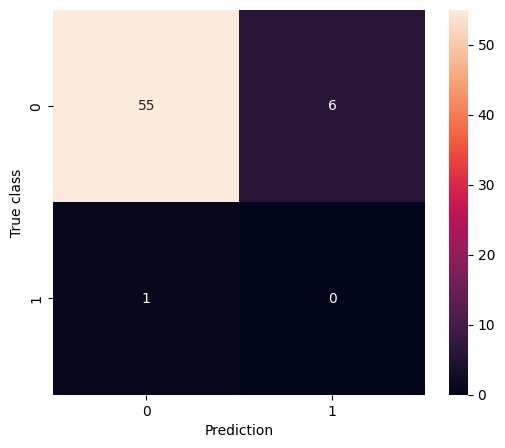

In [123]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [124]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

'              precision    recall  f1-score   support\n\n       False       0.98      1.00      0.99        61\n        True       0.00      0.00      0.00         1\n\n    accuracy                           0.98        62\n   macro avg       0.49      0.50      0.50        62\nweighted avg       0.97      0.98      0.98        62\n'

Text(45.722222222222214, 0.5, 'True class')

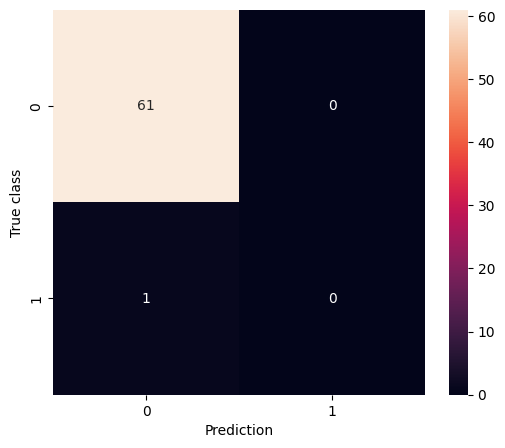

In [125]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [126]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

'              precision    recall  f1-score   support\n\n       False       0.98      1.00      0.99        61\n        True       0.00      0.00      0.00         1\n\n    accuracy                           0.98        62\n   macro avg       0.49      0.50      0.50        62\nweighted avg       0.97      0.98      0.98        62\n'

Text(45.722222222222214, 0.5, 'True class')

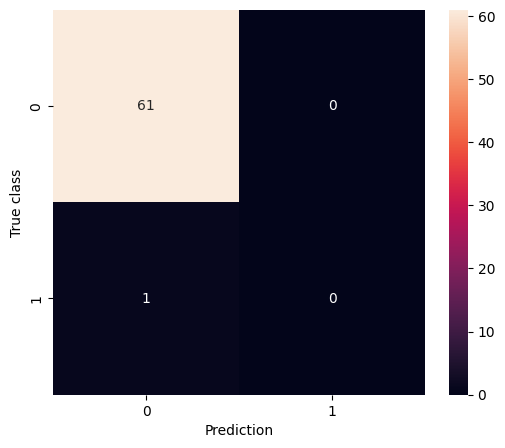

In [127]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [128]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site

'              precision    recall  f1-score   support\n\n       False       0.98      1.00      0.99        61\n        True       0.00      0.00      0.00         1\n\n    accuracy                           0.98        62\n   macro avg       0.49      0.50      0.50        62\nweighted avg       0.97      0.98      0.98        62\n'

Text(45.722222222222214, 0.5, 'True class')

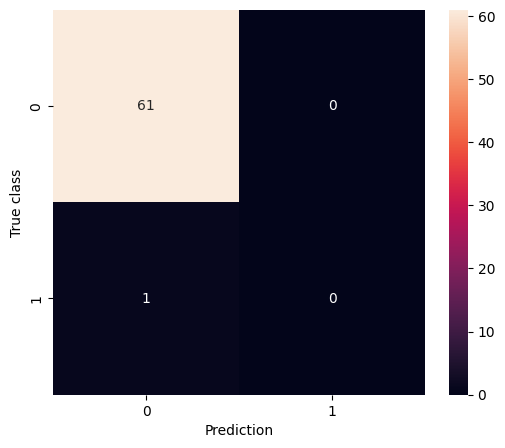

In [129]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [130]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

'              precision    recall  f1-score   support\n\n       False       0.98      1.00      0.99        61\n        True       0.00      0.00      0.00         1\n\n    accuracy                           0.98        62\n   macro avg       0.49      0.50      0.50        62\nweighted avg       0.97      0.98      0.98        62\n'

Text(45.722222222222214, 0.5, 'True class')

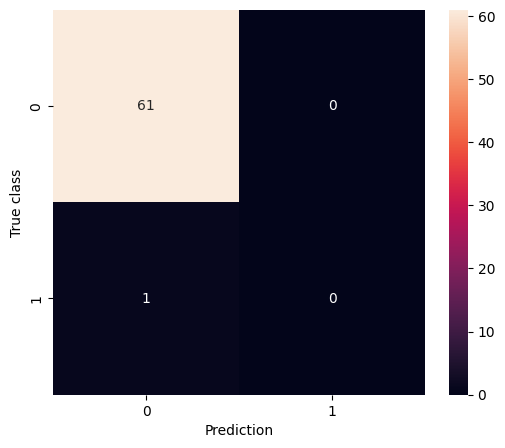

In [131]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [132]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

'              precision    recall  f1-score   support\n\n       False       0.98      1.00      0.99        61\n        True       0.00      0.00      0.00         1\n\n    accuracy                           0.98        62\n   macro avg       0.49      0.50      0.50        62\nweighted avg       0.97      0.98      0.98        62\n'

Text(45.722222222222214, 0.5, 'True class')

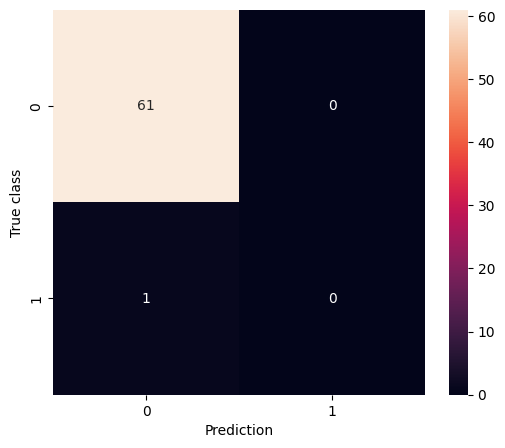

In [133]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

## Ragequit T+12

In [ ]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout_t+1', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'burnout', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1).dropna().astype({'ragequit_t+12':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['ragequit_t+12'])

In [ ]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('ragequit_t+12', axis = 1), logistic_train_data['ragequit_t+12'])

In [ ]:
cm = confusion_matrix(logistic_test_data['ragequit_t+12'], lr_model.predict(logistic_test_data.drop('ragequit_t+12', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [ ]:
stat_model = sm.Logit(logistic_train_data['ragequit_t+12'].astype(float), sm.add_constant(logistic_train_data[['Avg. distance', 'standardized_workload',
 'Organisational Silo',  'black_cloud', 'Messages Sent', 'reply_degree']]).astype(float)).fit(disp = 0)
stat_model.summary()

In [ ]:
cm = confusion_matrix(logistic_test_data['ragequit_t+12'], round(stat_model.predict(sm.add_constant(logistic_test_data[['Avg. distance', 'standardized_workload',
 'Organisational Silo',  'black_cloud', 'Messages Sent', 'reply_degree']]).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [134]:
message_data = all_test[['reply_body', 'ragequit_t+12']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['ragequit_t+12'] = message_data['ragequit_t+12'].astype(bool)
message_data

100%|██████████| 423/423 [00:03<00:00, 106.60it/s]


,reply_body,ragequit_t+12,lemmas
0,check,False,[check]
1,i have written down one on the user the does t...,False,"[write, user, create, number, ledger, reach, l..."
2,check,False,[check]
3,NegativeSentiment test NegativeSentiment test,False,"[NegativeSentiment, test, NegativeSentiment, t..."
4,test failure when checking the release,False,"[test, failure, check, release]"
...,...,...,...
429,"currently, bookkeeper client still write ledge...",False,"[currently, bookkeeper, client, write, ledger,..."
430,we changed ledgers to let consumed messages be...,False,"[change, ledger, let, consume, message, garbag..."
431,if there are lots of pending topic we should h...,False,"[lot, pende, topic, hub, pende, request, acces..."
432,currently use same ledger metadata during ledg...,False,"[currently, use, ledger, metadata, ledger, wri..."


In [135]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['ragequit_t+12'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['ragequit_t+12'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["ragequit_t+12"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["ragequit_t+12"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+12"]==1].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')

        if 3*message_train["ragequit_t+12"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+12"]==1].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')

        nMax = message_train["ragequit_t+12"].sum()
        message_train = message_train.groupby("ragequit_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["ragequit_t+12"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')
        message_train = message_train.groupby("ragequit_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["ragequit_t+12"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+12"]==0].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')

        if message_train["ragequit_t+12"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+12"]==0].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')

        nMax = len(message_train) - message_train["ragequit_t+12"].sum()
        message_train = message_train.groupby("ragequit_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["ragequit_t+12"].sum()
        print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')
        message_train = message_train.groupby("ragequit_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 284
length of validation set: 62
length of test set: 62
Positive cases: 16
Positive cases: 48
New length of train set: 96


C:\Users\woute\AppData\Local\Temp\ipykernel_19704\2668262174.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_19704\2668262174.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("ragequit_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [136]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['ragequit_t+12']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['ragequit_t+12']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
                   pos_importance  pos_occur  total_appearances
ledger                   0.030612        6.0              196.0
entry                    0.000000        0.0              122.0
PositiveSentiment        0.000000        0.0              115.0
bookie                   0.000000        0.0              146.0
negative 0:
                   neg_importance  neg_occur  total_appearances
entry                    1.000000      122.0              122.0
PositiveSentiment        1.000000      115.0              115.0
bookie                   1.000000      146.0              146.0
ledger                   0.969388      190.0              196.0
----------------------------------------------------------------------------------------------------------------------------------------------
positive 25:
                   pos_importance  pos_occur  total_appearances
PositiveSentiment        0.151515        0.0              115.0
entry                    0.145349        0.0        

In [137]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.96      0.85      0.90        59\n        True       0.10      0.33      0.15         3\n\n    accuracy                           0.82        62\n   macro avg       0.53      0.59      0.53        62\nweighted avg       0.92      0.82      0.86        62\n'

Text(45.722222222222214, 0.5, 'True class')

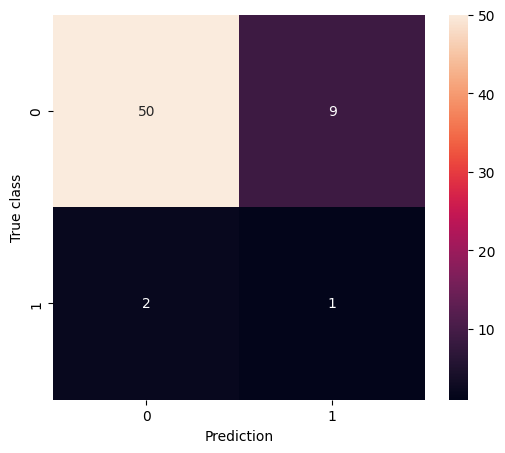

In [138]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [139]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.94      0.81      0.87        59\n        True       0.00      0.00      0.00         3\n\n    accuracy                           0.77        62\n   macro avg       0.47      0.41      0.44        62\nweighted avg       0.90      0.77      0.83        62\n'

Text(45.722222222222214, 0.5, 'True class')

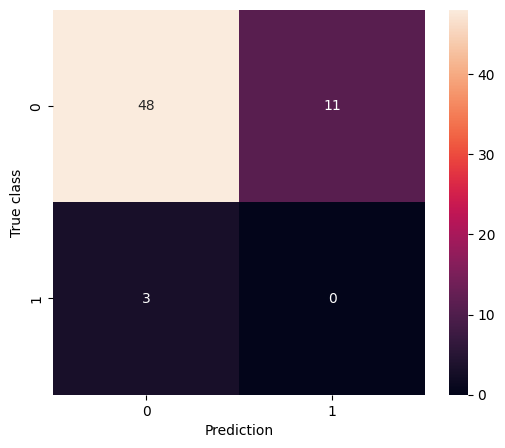

In [140]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [141]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.95      0.97      0.96        59\n        True       0.00      0.00      0.00         3\n\n    accuracy                           0.92        62\n   macro avg       0.47      0.48      0.48        62\nweighted avg       0.90      0.92      0.91        62\n'

Text(45.722222222222214, 0.5, 'True class')

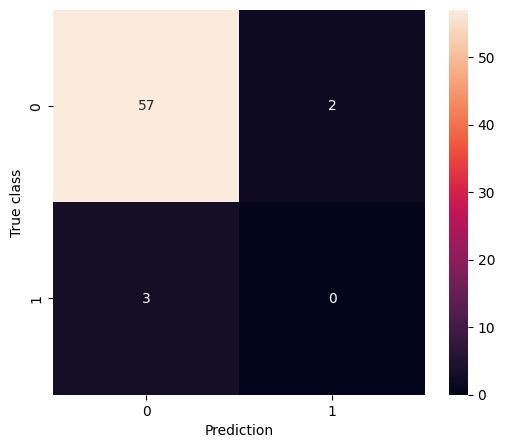

In [142]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [143]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.95      0.98      0.97        59\n        True       0.00      0.00      0.00         3\n\n    accuracy                           0.94        62\n   macro avg       0.48      0.49      0.48        62\nweighted avg       0.90      0.94      0.92        62\n'

Text(45.722222222222214, 0.5, 'True class')

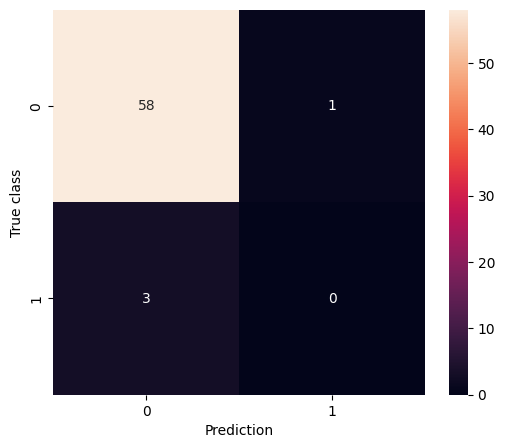

In [144]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [145]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.95      0.90      0.92        59\n        True       0.00      0.00      0.00         3\n\n    accuracy                           0.85        62\n   macro avg       0.47      0.45      0.46        62\nweighted avg       0.90      0.85      0.88        62\n'

Text(45.722222222222214, 0.5, 'True class')

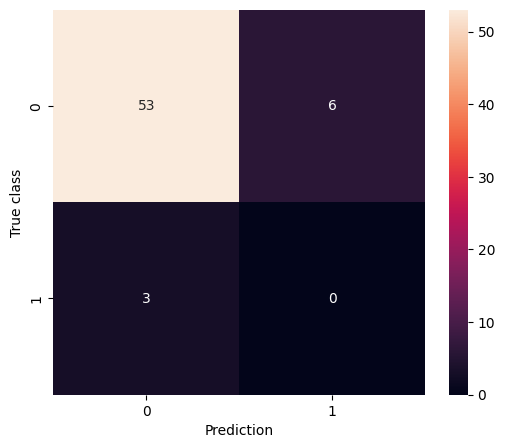

In [146]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [147]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.95      0.98      0.97        59\n        True       0.00      0.00      0.00         3\n\n    accuracy                           0.94        62\n   macro avg       0.48      0.49      0.48        62\nweighted avg       0.90      0.94      0.92        62\n'

Text(45.722222222222214, 0.5, 'True class')

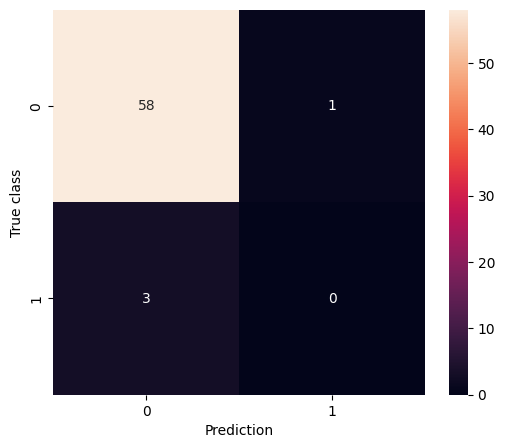

In [148]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')